# 03 - Clustering: K-Means e DBSCAN

## CRISP-DM: Fase de Modelação - Experiência 1 (Aprendizagem Não Supervisionada)

Este notebook implementa algoritmos de **clustering** para identificar perfis de consumidores no dataset D4Maia, seguindo a metodologia CRISP-DM.

### Objetivos:
1. **K-Means**: Identificar grupos de consumidores com base em features agregadas
2. **DBSCAN**: Detetar outliers e clusters de forma não paramétrica
3. **Normalização**: Avaliar impacto da normalização nos clusters
4. **Caracterização**: Interpretar perfis de consumo (diurno, noturno, 24/7, etc.)

### Métricas de Avaliação:
- **Silhouette Score**: Mede a qualidade da separação dos clusters [-1, 1]
- **Calinski-Harabasz Index**: Rácio de dispersão inter/intra clusters
- **Davies-Bouldin Index**: Média das semelhanças entre clusters (menor = melhor)
- **Proporção de ruído** (DBSCAN): Percentagem de pontos não atribuídos

### Estrutura do Notebook:
1. Importação e configuração
2. Carregamento de features por CPE
3. Análise e seleção de features
4. K-Means sem normalização
5. K-Means com normalização
6. DBSCAN com diferentes parâmetros
7. Comparação de métodos
8. Caracterização dos perfis
9. Visualizações (PCA)
10. Guardar resultados
11. Conclusões

---

**Referência do Enunciado:**
> "Usar algoritmos de clustering (K-Means e DBSCAN) para identificar sub-grupos de consumidores,
> detetar outliers e, se possível, relacionar perfis com tipos de serviços (diurnos, noturnos, 24/7)."

In [315]:
# MELHORAMENTO: Sistema de constantes configuráveis organizado
# =================================================================================
# CONFIGURAÇÕES GERAIS
# =================================================================================
RANDOM_STATE = 42     # Seed para reprodutibilidade
VERBOSE = True         # Controle de outputs verbosos
SAVE_RESULTS = True    # Salvar automaticamente os resultados

# =================================================================================
# CONFIGURAÇÕES DE CLUSTERING
# =================================================================================
# K-Means
K_RANGE_DEFAULT = range(2, 11)  # Range de k para testar
N_INIT_KMEANS = 10              # Número de inicializações K-Means
MAX_ITER_KMEANS = 300           # Máximo de iterações K-Means
MAX_CLUSTERS_ALLOWED = 10       # Máximo de clusters permitidos

# DBSCAN
EPS_RANGE = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]  # Valores de eps para testar
MIN_SAMPLES_RANGE = [2, 3, 5, 10]             # Valores de min_samples para testar

# =================================================================================
# CONFIGURAÇÕES DE VALIDAÇÃO E QUALIDADE
# =================================================================================
SILHOUETTE_THRESHOLD = 0.25     # Threshold mínimo para silhouette aceitável
NOISE_THRESHOLD_MAX = 40        # Máximo de ruído permitido (%)
MIN_CLUSTER_SIZE = 3            # Tamanho mínimo de cluster
MAX_OUTLIERS_PCT = 50           # Máximo de outliers permitidos (%)
IQR_MULTIPLIER = 1.5            # Multiplicador para detecção de outliers via IQR

# =================================================================================
# CONFIGURAÇÕES DE VISUALIZAÇÃO
# =================================================================================
FIG_SIZE_CLUSTERING = (12, 8)   # Tamanho padrão para gráficos de clustering
FIG_SIZE_COMPARISON = (14, 6)   # Tamanho para gráficos de comparação
PCA_COMPONENTS = 2              # Número de componentes PCA para visualização
ALPHA_SCATTER = 0.7             # Transparência dos pontos scatter
MARKER_SIZE_CLUSTER = 100       # Tamanho dos marcadores nos clusters
CENTROID_SIZE = 300             # Tamanho dos centróides

# =================================================================================
# CONFIGURAÇÕES DE PERFORMANCE
# =================================================================================
CHUNK_SIZE_PROCESSING = 10000   # Tamanho de chunks para processamento
TIMEOUT_CLUSTERING = 300        # Timeout para operações de clustering (segundos)
MEMORY_WARNING_MB = 1000        # Aviso de memória alta

# =================================================================================
# PALETA DE CORES CONSISTENTE
# =================================================================================
COLOR_PALETTE = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Alias para compatibilidade
COLORS = COLOR_PALETTE

# =================================================================================
# CONFIGURAÇÕES DINÂMICAS (baseadas no dataset)
# =================================================================================
# Estas configurações se adaptam automaticamente ao tamanho e características do dataset

def configurar_parametros_dinamicos_clustering(df_features):
    """
    Configura parâmetros dinâmicos baseados nas características do dataset de features.
    """
    n_cpes = len(df_features)
    n_features = len([col for col in df_features.columns if col not in ['CPE', 'n_registos']])

    # Ajustar range de k baseado no número de CPEs
    max_k_suggested = min(MAX_CLUSTERS_ALLOWED, max(3, int(np.sqrt(n_cpes))))
    k_range_dynamic = range(2, max_k_suggested + 1)

    # Ajustar eps range baseado no número de features (escala dos dados)
    eps_scale_factor = np.sqrt(n_features) / 5  # Fator de escala baseado na dimensionalidade
    eps_range_dynamic = [round(eps * eps_scale_factor, 2) for eps in [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]]

    # Ajustar min_samples baseado no tamanho do dataset
    min_samples_dynamic = [max(2, min(ms, n_cpes // 20)) for ms in MIN_SAMPLES_RANGE]

    # Ajustar thresholds baseado no tamanho do dataset
    silhouette_threshold_dynamic = max(0.1, SILHOUETTE_THRESHOLD - (n_cpes / 10000) * 0.1)
    noise_threshold_dynamic = min(60, NOISE_THRESHOLD_MAX + (n_cpes / 1000))

    return {
        'k_range': k_range_dynamic,
        'eps_range': eps_range_dynamic,
        'min_samples_range': min_samples_dynamic,
        'silhouette_threshold': silhouette_threshold_dynamic,
        'noise_threshold': noise_threshold_dynamic,
        'n_cpes': n_cpes,
        'n_features': n_features
    }

# Placeholder - será configurado após carregar dados
CONFIG_DINAMICA_CLUSTERING = {}

print("Sistema de constantes configuráveis para clustering inicializado!")
print("Parâmetros dinâmicos serão ajustados após carregamento dos dados.")

# Bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import time

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Seed para reprodutibilidade
np.random.seed(RANDOM_STATE)

print("Bibliotecas importadas com sucesso!")

Sistema de constantes configuráveis para clustering inicializado!
Parâmetros dinâmicos serão ajustados após carregamento dos dados.
Bibliotecas importadas com sucesso!


In [316]:
# MELHORAMENTO: Carregamento com validações robustas
features_path = 'data/intermediate/d4maia_cpe_features.csv'

print("A carregar features por CPE...")
print("=" * 50)

# Verificar se arquivo existe
if not os.path.exists(features_path):
    raise FileNotFoundError(f"Arquivo de features não encontrado: {features_path}")

# Verificar se diretório existe
features_dir = os.path.dirname(features_path)
if not os.path.exists(features_dir):
    os.makedirs(features_dir, exist_ok=True)
    print(f"Diretório criado: {features_dir}")

try:
    df_features = pd.read_csv(features_path)
    print(f"✓ Dados carregados com sucesso!")
    print(f"  - Arquivo: {features_path}")
    print(f"  - Dimensões: {df_features.shape[0]} CPEs × {df_features.shape[1]} colunas")
except Exception as e:
    print(f"✗ Erro ao carregar dados: {e}")
    raise

# =================================================================================
# VALIDAÇÕES DE QUALIDADE DOS DADOS
# =================================================================================
print(f"\n🔍 VALIDAÇÕES DE QUALIDADE:")
print("-" * 30)

# Verificar se coluna CPE existe
if 'CPE' not in df_features.columns:
    raise ValueError("Coluna 'CPE' não encontrada no dataset de features")

# Verificar número mínimo de CPEs
if len(df_features) < 10:
    raise ValueError(f"Número insuficiente de CPEs: {len(df_features)} (mínimo: 10)")

# Verificar se há features suficientes
feature_cols = [col for col in df_features.columns if col not in ['CPE', 'n_registos']]
if len(feature_cols) < 3:
    raise ValueError(f"Número insuficiente de features: {len(feature_cols)} (mínimo: 3)")

print(f"✓ Coluna identificadora 'CPE': OK")
print(f"✓ Número de CPEs: {len(df_features)} (mínimo: 10)")
print(f"✓ Número de features: {len(feature_cols)} (mínimo: 3)")

# Verificar valores nulos
null_counts = df_features[feature_cols].isnull().sum()
total_nulls = null_counts.sum()
if total_nulls > 0:
    print(f"⚠️  Valores nulos encontrados: {total_nulls}")
    print(f"   Features com nulos: {sum(null_counts > 0)}")
    # Preencher nulos com mediana (mais robusto que média)
    for col in feature_cols:
        if df_features[col].isnull().sum() > 0:
            median_val = df_features[col].median()
            df_features[col] = df_features[col].fillna(median_val)
            print(f"   ✓ Preenchidos {df_features[col].isnull().sum()} nulos em '{col}' com mediana {median_val:.3f}")
else:
    print("✓ Valores nulos: Nenhum encontrado")

# =================================================================================
# CONFIGURAR PARÂMETROS DINÂMICOS APÓS CARREGAMENTO
# =================================================================================
CONFIG_DINAMICA_CLUSTERING = configurar_parametros_dinamicos_clustering(df_features)

print(f"\n📊 CONFIGURAÇÕES DINÂMICAS AJUSTADAS:")
print(f"  - Range dinâmico de k: {list(CONFIG_DINAMICA_CLUSTERING['k_range'])} (vs {list(K_RANGE_DEFAULT)} padrão)")
print(f"  - Range dinâmico de eps: {CONFIG_DINAMICA_CLUSTERING['eps_range'][:3]}... (vs {EPS_RANGE[:3]}... padrão)")
print(f"  - Threshold silhouette dinâmico: {CONFIG_DINAMICA_CLUSTERING['silhouette_threshold']:.3f} (vs {SILHOUETTE_THRESHOLD:.3f} padrão)")
print(f"  - Threshold ruído dinâmico: {CONFIG_DINAMICA_CLUSTERING['noise_threshold']:.1f}% (vs {NOISE_THRESHOLD_MAX:.1f}% padrão)")

# Usar configurações dinâmicas
K_RANGE_ATUAL = CONFIG_DINAMICA_CLUSTERING['k_range']
EPS_RANGE_ATUAL = CONFIG_DINAMICA_CLUSTERING['eps_range']
MIN_SAMPLES_RANGE_ATUAL = CONFIG_DINAMICA_CLUSTERING['min_samples_range']
SILHOUETTE_THRESHOLD_ATUAL = CONFIG_DINAMICA_CLUSTERING['silhouette_threshold']
NOISE_THRESHOLD_ATUAL = CONFIG_DINAMICA_CLUSTERING['noise_threshold']

# =================================================================================
# FUNÇÕES AUXILIARES PARA CLUSTERING
# =================================================================================

def avaliar_cluster_qualidade(X, labels, nome_algoritmo="Algoritmo"):
    """
    Avalia a qualidade de um resultado de clustering com múltiplas métricas.
    """
    resultados = {'algoritmo': nome_algoritmo}

    # Número de clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1) if -1 in labels else 0
    noise_pct = n_noise / len(labels) * 100

    resultados.update({
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct
    })

    # Métricas de qualidade (apenas se houver clusters válidos)
    if n_clusters > 1 and n_noise < len(labels):
        # Silhouette (apenas para pontos não-ruído)
        mask = labels != -1
        if len(set(labels[mask])) > 1:
            resultados['silhouette'] = silhouette_score(X[mask], labels[mask])
        else:
            resultados['silhouette'] = np.nan

        # Calinski-Harabasz Index
        try:
            resultados['calinski_harabasz'] = calinski_harabasz_score(X[mask], labels[mask])
        except:
            resultados['calinski_harabasz'] = np.nan

        # Davies-Bouldin Index
        try:
            resultados['davies_bouldin'] = davies_bouldin_score(X[mask], labels[mask])
        except:
            resultados['davies_bouldin'] = np.nan
    else:
        resultados.update({
            'silhouette': np.nan,
            'calinski_harabasz': np.nan,
            'davies_bouldin': np.nan
        })

    return resultados

def plot_silhouette_analysis(X, labels, titulo="Análise de Silhouette"):
    """
    Plota análise detalhada de silhouette por cluster.
    """
    if len(set(labels)) <= 1:
        print("Não é possível plotar silhouette: apenas 1 cluster ou menos")
        return

    # Calcular silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    fig, ax = plt.subplots(figsize=FIG_SIZE_COMPARISON)

    y_lower = 10
    cluster_labels = sorted(set(labels))

    for i, cluster in enumerate(cluster_labels):
        if cluster == -1:  # Ruído
            continue

        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()

        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        color = COLORS[cluster % len(COLORS)]
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                        facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(cluster))
        y_lower = y_upper + 10

    ax.set_xlabel("Coeficiente de Silhouette")
    ax.set_ylabel("Cluster")
    ax.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--",
               label=f"Média: {np.mean(silhouette_vals):.3f}")
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.legend()

    plt.tight_layout()
    plt.show()

def comparar_clusters_estatisticamente(df_features, cluster_col, features_interesse=None):
    """
    Compara clusters estatisticamente usando testes não-paramétricos.
    """
    if features_interesse is None:
        features_interesse = ['consumo_mean', 'consumo_std', 'consumo_cv',
                             'racio_dia_noite', 'racio_weekend_util']

    features_disponiveis = [f for f in features_interesse if f in df_features.columns]

    print("COMPARAÇÃO ESTATÍSTICA ENTRE CLUSTERS")
    print("=" * 50)

    resultados = []

    for feature in features_disponiveis:
        clusters_data = []
        cluster_labels = []

        for cluster in sorted(df_features[cluster_col].unique()):
            if cluster == -1:  # Pular ruído
                continue

            data_cluster = df_features[df_features[cluster_col] == cluster][feature].dropna()
            if len(data_cluster) > 0:
                clusters_data.append(data_cluster.values)
                cluster_labels.append(f"Cluster {cluster}")

        if len(clusters_data) >= 2:
            # Teste de Kruskal-Wallis (não-paramétrico para > 2 grupos)
            try:
                h_stat, p_val = stats.kruskal(*clusters_data)
                significativo = "SIM" if p_val < 0.05 else "NÃO"

                resultados.append({
                    'feature': feature,
                    'h_statistic': h_stat,
                    'p_value': p_val,
                    'significativo': significativo,
                    'n_clusters': len(clusters_data)
                })

                print(f"{feature}:")
                print(f"  H-statistic: {h_stat:.3f}, p-value: {p_val:.4f} → Diferenças {'significativas' if p_val < 0.05 else 'não significativas'}")
            except Exception as e:
                print(f"{feature}: Erro no teste estatístico - {e}")

    return pd.DataFrame(resultados)

print("Funções auxiliares para clustering carregadas!")

A carregar features por CPE...
✓ Dados carregados com sucesso!
  - Arquivo: data/intermediate/d4maia_cpe_features.csv
  - Dimensões: 89 CPEs × 59 colunas

🔍 VALIDAÇÕES DE QUALIDADE:
------------------------------
✓ Coluna identificadora 'CPE': OK
✓ Número de CPEs: 89 (mínimo: 10)
✓ Número de features: 57 (mínimo: 3)
✓ Valores nulos: Nenhum encontrado

📊 CONFIGURAÇÕES DINÂMICAS AJUSTADAS:
  - Range dinâmico de k: [2, 3, 4, 5, 6, 7, 8, 9] (vs [2, 3, 4, 5, 6, 7, 8, 9, 10] padrão)
  - Range dinâmico de eps: [np.float64(0.45), np.float64(0.75), np.float64(1.06)]... (vs [0.3, 0.5, 0.7]... padrão)
  - Threshold silhouette dinâmico: 0.249 (vs 0.250 padrão)
  - Threshold ruído dinâmico: 40.1% (vs 40.0% padrão)
Funções auxiliares para clustering carregadas!


Funções auxiliares para clustering carregadas!

📊 ANÁLISE EXPLORATÓRIA DOS DADOS:

Estatísticas descritivas das 57 features:
                               count    mean      std    min     25%     50%  \
consumo_mean                 89.0000  8.4710  24.3130 0.0000  0.6330  3.1150   
consumo_std                  89.0000  5.8970  11.9650 0.0000  0.6900  3.1740   
consumo_min                  89.0000  0.0000   0.0000 0.0000  0.0000  0.0000   
consumo_max                  89.0000 41.5540  83.4530 0.0000  5.0000 22.1760   
consumo_median               89.0000  6.4760  21.9540 0.0000  0.1160  1.2160   
consumo_q25                  89.0000  4.2400  14.9560 0.0000  0.0280  0.7480   
consumo_q75                  89.0000 11.2610  33.4330 0.0000  1.0000  4.0000   
consumo_cv                   89.0000  1.2490   1.3110 0.0890  0.8140  1.0350   
consumo_iqr_norm             89.0000  0.9460   0.6070 0.0000  0.5150  0.9420   
consumo_noite                89.0000  6.4440  17.5380 0.0000  0.5310  2.328

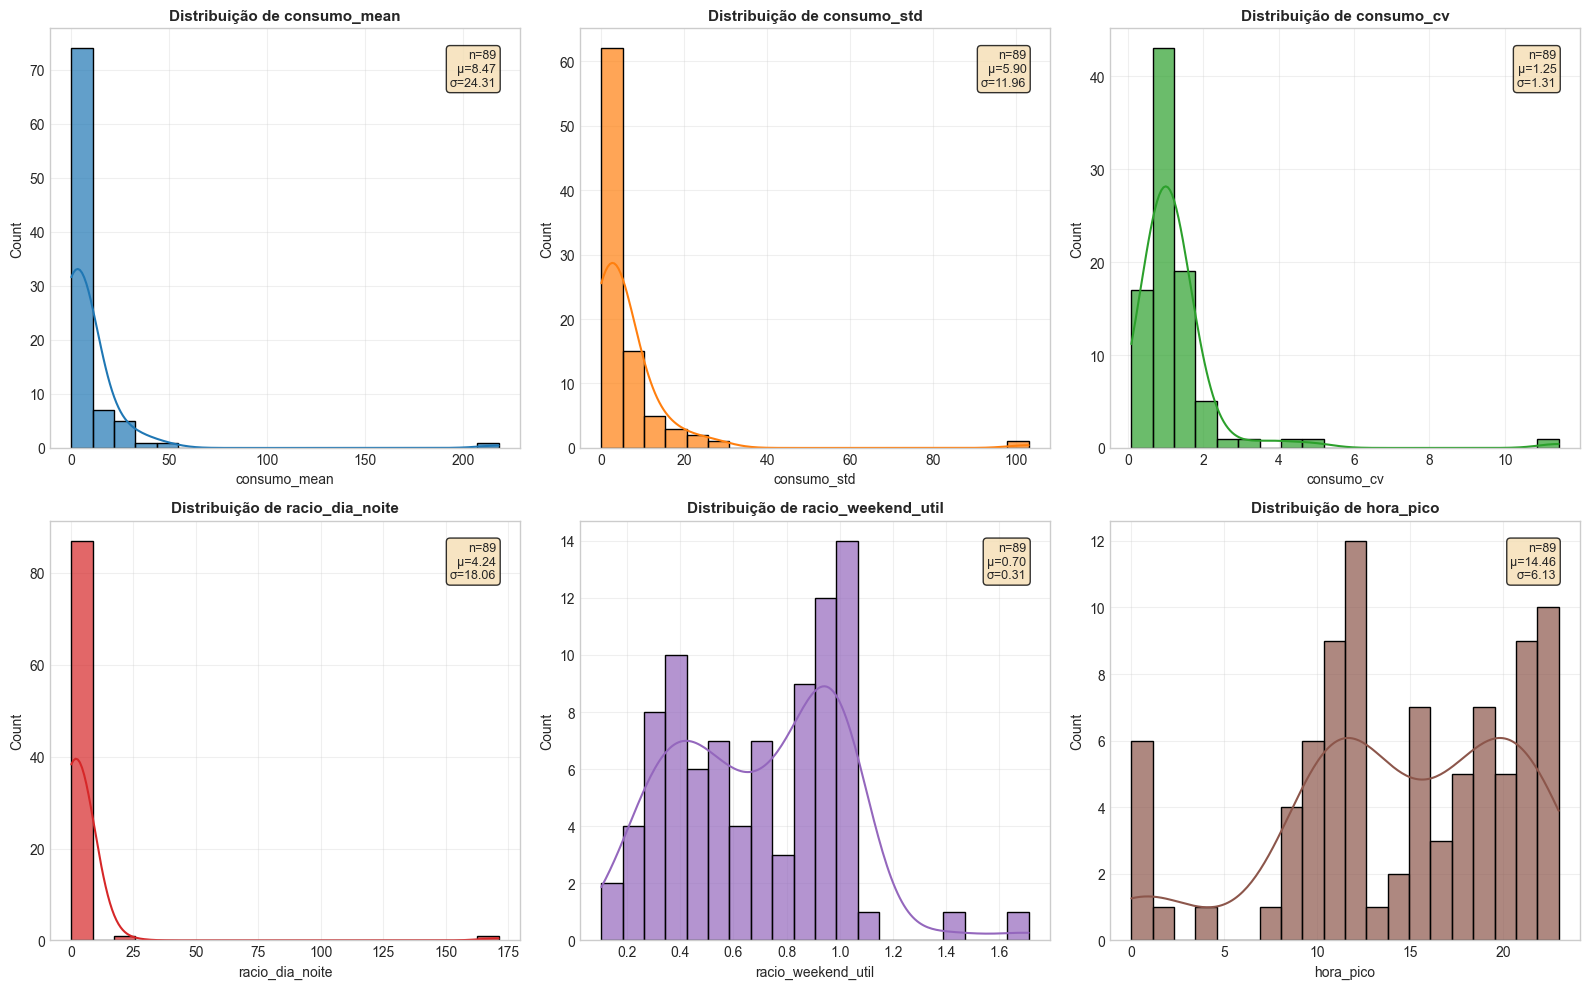


🔗 MATRIZ DE CORRELAÇÃO:


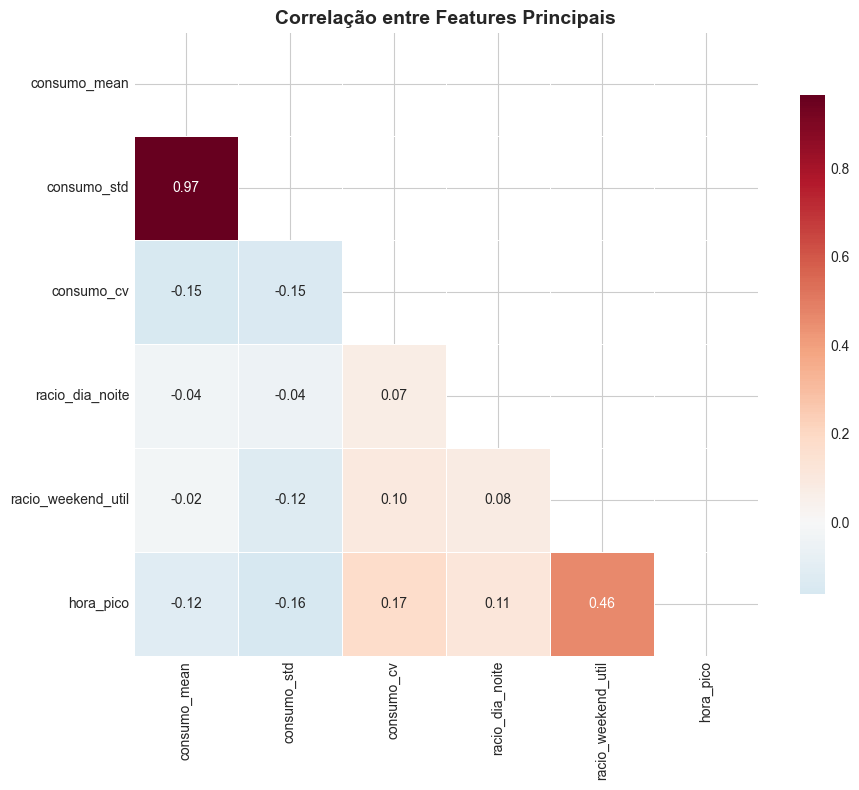

⚠️  CORRELAÇÕES ALTAS DETECTADAS (|ρ| > 0.8):
   consumo_mean ↔ consumo_std: 0.966

✅ ANÁLISE EXPLORATÓRIA CONCLUÍDA!
   Dados prontos para clustering: 89 CPEs × 57 features


In [317]:
print("Funções auxiliares para clustering carregadas!")

# =================================================================================
# ANÁLISE EXPLORATÓRIA INICIAL DOS DADOS
# =================================================================================

print(f"\n📊 ANÁLISE EXPLORATÓRIA DOS DADOS:")
print("=" * 40)

# Estatísticas descritivas das features
print(f"\nEstatísticas descritivas das {len(feature_cols)} features:")
stats_desc = df_features[feature_cols].describe().T
print(stats_desc.round(3))

# Verificar distribuição das features
print(f"\n📈 DISTRIBUIÇÃO DAS FEATURES PRINCIPAIS:")
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

features_principais = ['consumo_mean', 'consumo_std', 'consumo_cv',
                      'racio_dia_noite', 'racio_weekend_util', 'hora_pico']

for i, feature in enumerate(features_principais):
    if feature in df_features.columns and i < len(axes):
        ax = axes[i]
        data = df_features[feature].dropna()

        if len(data) > 0:
            # Histograma com KDE
            sns.histplot(data, bins=20, kde=True, ax=ax, color=COLORS[i % len(COLORS)], alpha=0.7)

            # Estatísticas no gráfico
            stats_text = f'n={len(data)}\nμ={data.mean():.2f}\nσ={data.std():.2f}'
            ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                   fontsize=9, va='top', ha='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax.set_title(f'Distribuição de {feature}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

# Remover axes vazios
for i in range(len(features_principais), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Matriz de correlação das features principais
print(f"\n🔗 MATRIZ DE CORRELAÇÃO:")
if len(features_principais) > 1:
    corr_matrix = df_features[features_principais].corr()

    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, ax=ax, mask=mask,
                cbar_kws={'shrink': 0.8})
    ax.set_title('Correlação entre Features Principais', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Identificar correlações altas
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            if corr_val > 0.8:
                high_corr.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })

    if high_corr:
        print("⚠️  CORRELAÇÕES ALTAS DETECTADAS (|ρ| > 0.8):")
        for corr in high_corr:
            print(f"   {corr['feature1']} ↔ {corr['feature2']}: {corr['correlation']:.3f}")
    else:
        print("✅ Nenhuma correlação alta detectada entre features principais.")

print(f"\n✅ ANÁLISE EXPLORATÓRIA CONCLUÍDA!")
print(f"   Dados prontos para clustering: {len(df_features)} CPEs × {len(feature_cols)} features")

In [318]:
# Estatísticas descritivas
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
consumo_mean,89.0000,8.4710,24.3130,0.0000,0.6331,3.1153,6.0229,218.1930
consumo_std,89.0000,5.8974,11.9649,0.0000,0.6902,3.1738,5.7351,103.0954
consumo_min,89.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
consumo_max,89.0000,41.5542,83.4533,0.0000,5.0000,22.1760,37.0000,574.0000
consumo_median,89.0000,6.4765,21.9542,0.0000,0.1160,1.2160,3.0000,196.0000
consumo_q25,89.0000,4.2402,14.9564,0.0000,0.0280,0.7480,3.0000,130.0000
consumo_q75,89.0000,11.2612,33.4326,0.0000,1.0000,4.0000,8.8740,303.0000
n_registos,89.0000,65598.3820,18071.4199,14490.0000,46643.0000,78702.0000,78802.0000,81776.0000
consumo_cv,89.0000,1.2490,1.3114,0.0892,0.8143,1.0354,1.2921,11.4296
consumo_iqr_norm,89.0000,0.9459,0.6066,0.0000,0.5145,0.9415,1.3131,2.8069


## 2. Preparação dos Dados para Clustering

In [319]:
# =================================================================================
# PREPARAÇÃO AVANÇADA DOS DADOS PARA CLUSTERING
# =================================================================================

print("PREPARAÇÃO AVANÇADA DOS DADOS PARA CLUSTERING")
print("=" * 60)

# Separar identificadores e features
cpe_ids = df_features['CPE'].values

# Selecionar apenas colunas numéricas para clustering (excluir CPE e n_registos)
cols_to_exclude = ['CPE', 'n_registos']
feature_cols = [col for col in df_features.columns if col not in cols_to_exclude]

# Verificar se há colunas não numéricas
numeric_cols = df_features[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Features selecionadas para clustering: {len(numeric_cols)}")
print(f"\nFeatures:")
for i, col in enumerate(numeric_cols, 1):
    print(f"  {i:2d}. {col}")

PREPARAÇÃO AVANÇADA DOS DADOS PARA CLUSTERING
Features selecionadas para clustering: 57

Features:
   1. consumo_mean
   2. consumo_std
   3. consumo_min
   4. consumo_max
   5. consumo_median
   6. consumo_q25
   7. consumo_q75
   8. consumo_cv
   9. consumo_iqr_norm
  10. consumo_noite
  11. consumo_manhã
  12. consumo_tarde
  13. consumo_h00
  14. consumo_h01
  15. consumo_h02
  16. consumo_h03
  17. consumo_h04
  18. consumo_h05
  19. consumo_h06
  20. consumo_h07
  21. consumo_h08
  22. consumo_h09
  23. consumo_h10
  24. consumo_h11
  25. consumo_h12
  26. consumo_h13
  27. consumo_h14
  28. consumo_h15
  29. consumo_h16
  30. consumo_h17
  31. consumo_h18
  32. consumo_h19
  33. consumo_h20
  34. consumo_h21
  35. consumo_h22
  36. consumo_h23
  37. consumo_seg
  38. consumo_ter
  39. consumo_qua
  40. consumo_qui
  41. consumo_sex
  42. consumo_sab
  43. consumo_dom
  44. consumo_dias_uteis
  45. consumo_fim_semana
  46. racio_weekend_util
  47. hora_pico
  48. valor_pico
  49.

In [320]:
# =================================================================================
# VALIDAÇÃO ROBUSTA DA QUALIDADE DOS DADOS
# =================================================================================

print("\n🔍 VALIDAÇÃO ROBUSTA DA QUALIDADE DOS DADOS")
print("=" * 50)

# 1. Verificar valores nulos
null_counts = df_features[numeric_cols].isnull().sum()
total_nulls = null_counts.sum()
if total_nulls > 0:
    print(f"⚠️  Valores nulos encontrados: {total_nulls}")
    print(f"   Features com nulos: {sum(null_counts > 0)}")
    for col, count in null_counts[null_counts > 0].items():
        pct = count / len(df_features) * 100
        print(f"   • {col}: {count} nulos ({pct:.1f}%)")
    
    # Estratégia: Preencher com mediana (mais robusto que média)
    for col in numeric_cols:
        if df_features[col].isnull().sum() > 0:
            median_val = df_features[col].median()
            df_features[col] = df_features[col].fillna(median_val)
            print(f"   ✓ Preenchidos {df_features[col].isnull().sum()} nulos em '{col}' com mediana {median_val:.3f}")
else:
    print("✅ Valores nulos: Nenhum encontrado")

# 2. Verificar valores infinitos
inf_counts = np.isinf(df_features[numeric_cols]).sum()
total_inf = inf_counts.sum()
if total_inf > 0:
    print(f"\n⚠️  Valores infinitos encontrados: {total_inf}")
    for col, count in inf_counts[inf_counts > 0].iteritems():
        pct = count / len(df_features) * 100
        print(f"   • {col}: {count} infinitos ({pct:.1f}%)")
else:
    print("\n✅ Valores infinitos: Nenhum encontrado")

# 3. Verificar valores constantes (variância zero)
constant_cols = []
for col in numeric_cols:
    if df_features[col].var() == 0:
        constant_cols.append(col)

if constant_cols:
    print(f"\n⚠️  Features com variância zero (constantes): {len(constant_cols)}")
    for col in constant_cols:
        print(f"   • {col}: valor constante = {df_features[col].iloc[0]}")
    # Remover features constantes
    numeric_cols = [col for col in numeric_cols if col not in constant_cols]
    print(f"   ✓ Removidas {len(constant_cols)} features constantes")
else:
    print("\n✅ Features constantes: Nenhuma encontrada")

# 4. Verificar features com alta correlação (multicolinearidade)
if len(numeric_cols) > 1:
    corr_matrix = df_features[numeric_cols].corr().abs()
    high_corr_pairs = []
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            corr_val = corr_matrix.iloc[i, j]
            if corr_val > 0.95:  # Threshold alto para multicolinearidade
                high_corr_pairs.append({
                    'feature1': numeric_cols[i],
                    'feature2': numeric_cols[j],
                    'correlation': corr_val
                })
    
    if high_corr_pairs:
        print(f"\n⚠️  Pares com correlação muito alta (|ρ| > 0.95): {len(high_corr_pairs)}")
        for pair in high_corr_pairs:
            print(f"   • {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")
        print("   💡 Considerar remover uma das features em cada par para reduzir multicolinearidade")
    else:
        print("\n✅ Multicolinearidade alta: Nenhuma detectada")

print(f"\n📊 Resumo da validação:")
print(f"   • Features válidas para clustering: {len(numeric_cols)}")
print(f"   • CPEs totais: {len(df_features)}")


🔍 VALIDAÇÃO ROBUSTA DA QUALIDADE DOS DADOS
✅ Valores nulos: Nenhum encontrado

✅ Valores infinitos: Nenhum encontrado

⚠️  Features com variância zero (constantes): 1
   • consumo_min: valor constante = 0.0
   ✓ Removidas 1 features constantes

⚠️  Pares com correlação muito alta (|ρ| > 0.95): 967
   • consumo_mean ↔ consumo_std: 0.966
   • consumo_mean ↔ consumo_median: 0.995
   • consumo_mean ↔ consumo_q25: 0.983
   • consumo_mean ↔ consumo_q75: 0.998
   • consumo_mean ↔ consumo_noite: 0.994
   • consumo_mean ↔ consumo_manhã: 0.998
   • consumo_mean ↔ consumo_tarde: 0.997
   • consumo_mean ↔ consumo_h00: 0.970
   • consumo_mean ↔ consumo_h01: 0.958
   • consumo_mean ↔ consumo_h02: 0.957
   • consumo_mean ↔ consumo_h03: 0.963
   • consumo_mean ↔ consumo_h04: 0.971
   • consumo_mean ↔ consumo_h05: 0.980
   • consumo_mean ↔ consumo_h06: 0.985
   • consumo_mean ↔ consumo_h07: 0.992
   • consumo_mean ↔ consumo_h08: 0.993
   • consumo_mean ↔ consumo_h09: 0.996
   • consumo_mean ↔ consumo_


🔍 DETECÇÃO DE OUTLIERS NAS FEATURES
Outliers detectados por feature (método IQR):
                     feature  n_outliers pct_outliers           range
                consumo_mean          11        12.4%  [-7.45, 14.11]
                 consumo_std           9        10.1%  [-6.88, 13.30]
                 consumo_max           9        10.1% [-43.00, 85.00]
              consumo_median          12        13.5%   [-4.21, 7.33]
                 consumo_q25           9        10.1%   [-4.43, 7.46]
                 consumo_q75          10        11.2% [-10.81, 20.68]
                  consumo_cv           7         7.9%    [0.10, 2.01]
            consumo_iqr_norm           1         1.1%   [-0.68, 2.51]
               consumo_noite          14        15.7%  [-5.46, 10.51]
               consumo_manhã          10        11.2% [-13.13, 22.69]
               consumo_tarde          10        11.2% [-12.17, 21.05]
                 consumo_h00          13        14.6%  [-5.43, 10.40]
       

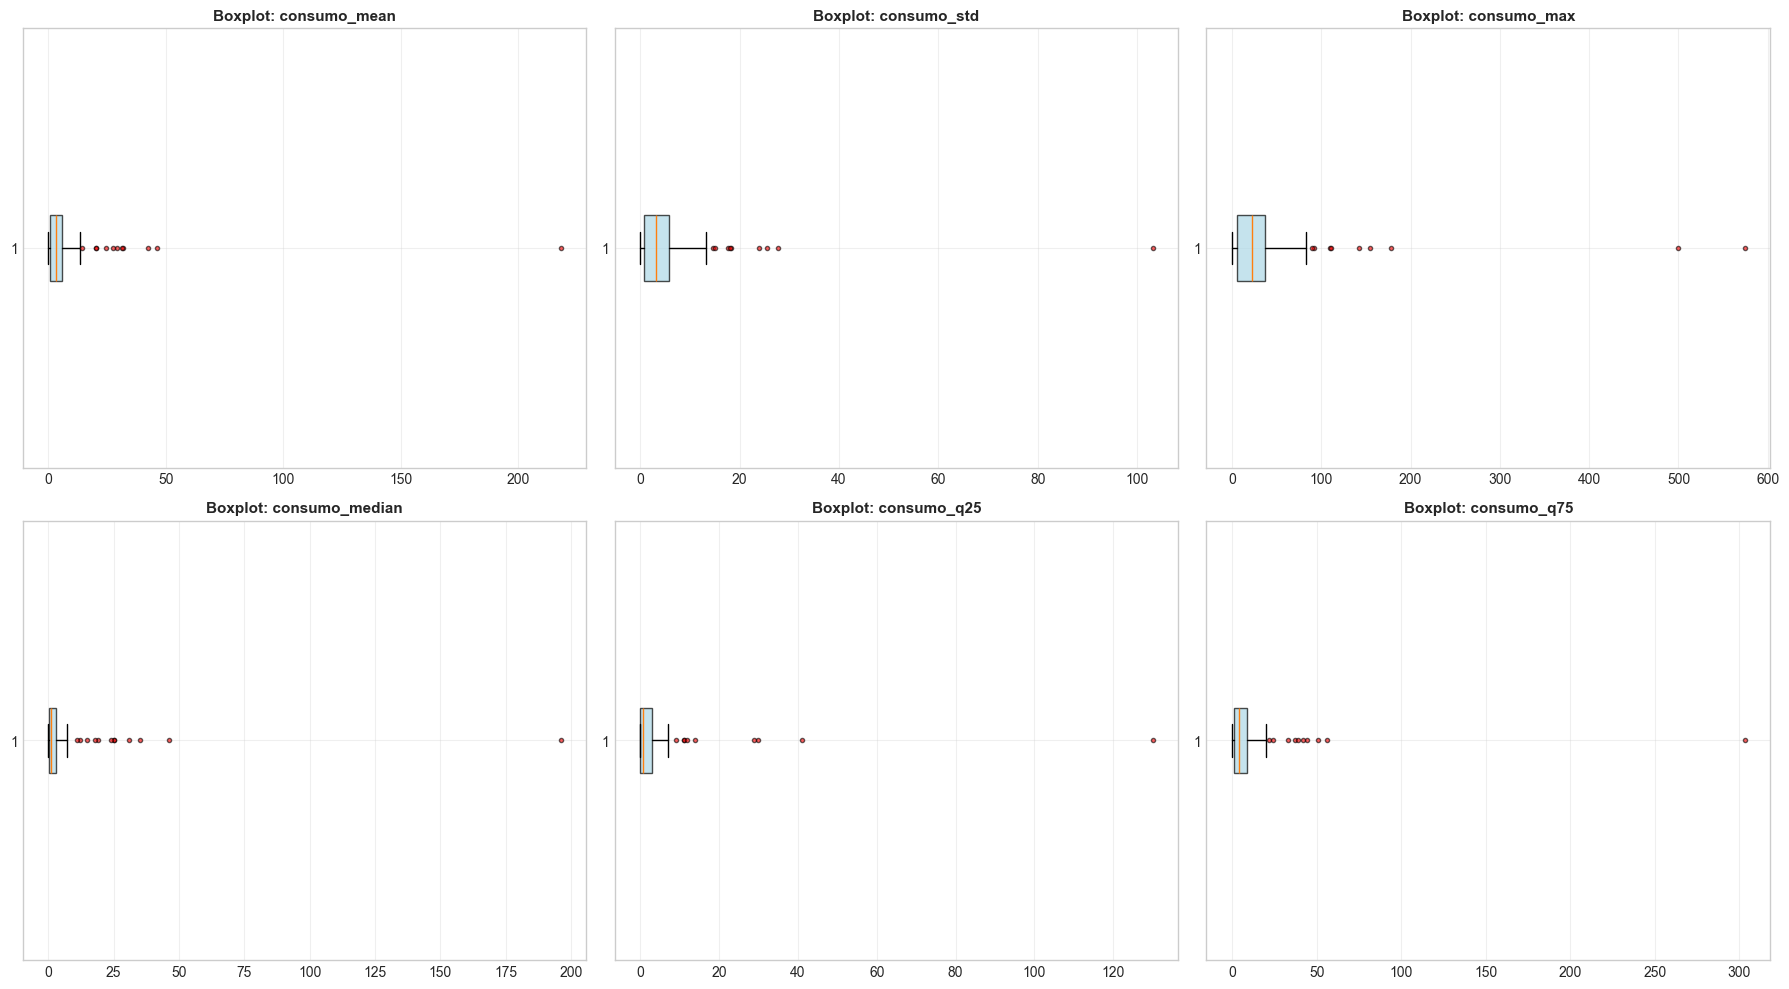

In [321]:
# =================================================================================
# DETECÇÃO DE OUTLIERS NAS FEATURES
# =================================================================================

print("\n🔍 DETECÇÃO DE OUTLIERS NAS FEATURES")
print("=" * 50)

# Usar IQR method para detectar outliers
def detectar_outliers_iqr(data, multiplier=IQR_MULTIPLIER):
    """Detecta outliers usando o método IQR."""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_summary = []
for col in numeric_cols:
    outliers, lower, upper = detectar_outliers_iqr(df_features[col])
    pct_outliers = len(outliers) / len(df_features) * 100
    outlier_summary.append({
        'feature': col,
        'n_outliers': len(outliers),
        'pct_outliers': pct_outliers,
        'range': f'[{lower:.2f}, {upper:.2f}]'
    })

outlier_df = pd.DataFrame(outlier_summary)
print("Outliers detectados por feature (método IQR):")
print("=" * 80)
print(outlier_df.to_string(index=False, formatters={'pct_outliers': '{:.1f}%'.format}))

# Identificar features com muitos outliers
high_outlier_features = outlier_df[outlier_df['pct_outliers'] > 10]['feature'].tolist()
if high_outlier_features:
    print(f"\n⚠️  Features com >10% outliers: {len(high_outlier_features)}")
    for feature in high_outlier_features:
        print(f"   • {feature}: {outlier_df[outlier_df['feature']==feature]['pct_outliers'].iloc[0]:.1f}% outliers")
    print("   💡 Considerar transformação logarítmica ou robusta normalização")
else:
    print("\n✅ Features com muitos outliers: Nenhuma encontrada")

# Visualizar distribuição de outliers para features principais
features_plot = numeric_cols[:6]  # Primeiras 6 features
if len(features_plot) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(features_plot):
        if i < len(axes):
            ax = axes[i]
            data = df_features[col].dropna()
            
            # Boxplot para visualizar outliers
            ax.boxplot(data, vert=False, patch_artist=True, 
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.6))
            
            ax.set_title(f'Boxplot: {col}', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
    
    # Remover axes vazios
    for i in range(len(features_plot), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [322]:
# =================================================================================
# CRIAÇÃO DA MATRIZ DE FEATURES
# =================================================================================

print("\n🔧 CRIAÇÃO DA MATRIZ DE FEATURES")
print("=" * 50)

# Criar matriz de features
X = df_features[numeric_cols].values

print(f"Matriz de features criada:")
print(f"  • Dimensões: {X.shape}")
print(f"  • {X.shape[0]} CPEs (linhas)")
print(f"  • {X.shape[1]} features (colunas)")

# Estatísticas finais da matriz
print(f"\n📊 Estatísticas da matriz de features:")
feature_stats = df_features[numeric_cols].describe().T[['count', 'mean', 'std', 'min', 'max']]
print(feature_stats.round(3))

# Verificar se há valores problemáticos finais
final_nulls = np.isnan(X).sum()
final_infs = np.isinf(X).sum()

print(f"\n🔍 Verificação final:")
print(f"  • Valores NaN: {final_nulls}")
print(f"  • Valores infinitos: {final_infs}")

if final_nulls > 0 or final_infs > 0:
    print("  ⚠️  Ainda há valores problemáticos. A corrigir...")
    X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)
    print("  ✓ Valores problemáticos corrigidos")
else:
    print("  ✅ Matriz pronta para clustering!")

print(f"\n✅ PREPARAÇÃO DOS DADOS CONCLUÍDA!")
print(f"   Matriz final: {X.shape[0]} × {X.shape[1]} (CPEs × Features)")


🔧 CRIAÇÃO DA MATRIZ DE FEATURES
Matriz de features criada:
  • Dimensões: (89, 56)
  • 89 CPEs (linhas)
  • 56 features (colunas)

📊 Estatísticas da matriz de features:
                               count    mean      std    min       max
consumo_mean                 89.0000  8.4710  24.3130 0.0000  218.1930
consumo_std                  89.0000  5.8970  11.9650 0.0000  103.0950
consumo_max                  89.0000 41.5540  83.4530 0.0000  574.0000
consumo_median               89.0000  6.4760  21.9540 0.0000  196.0000
consumo_q25                  89.0000  4.2400  14.9560 0.0000  130.0000
consumo_q75                  89.0000 11.2610  33.4330 0.0000  303.0000
consumo_cv                   89.0000  1.2490   1.3110 0.0890   11.4300
consumo_iqr_norm             89.0000  0.9460   0.6070 0.0000    2.8070
consumo_noite                89.0000  6.4440  17.5380 0.0000  153.9480
consumo_manhã                89.0000 10.2740  29.1120 0.0000  260.9060
consumo_tarde                89.0000 10.7200  33.

### 2.1 Normalização dos Dados

Vamos criar versões normalizadas dos dados para comparar o impacto da normalização no clustering.

In [323]:
# Normalização com StandardScaler (média=0, std=1)
scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(X)

# Normalização com MinMaxScaler (valores entre 0 e 1)
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)

print("Dados normalizados:")
print(f"\nOriginal:")
print(f"  - Média: {X.mean():.2f}, Std: {X.std():.2f}")
print(f"  - Min: {X.min():.2f}, Max: {X.max():.2f}")

print(f"\nStandardScaler:")
print(f"  - Média: {X_standard.mean():.4f}, Std: {X_standard.std():.4f}")
print(f"  - Min: {X_standard.min():.2f}, Max: {X_standard.max():.2f}")

print(f"\nMinMaxScaler:")
print(f"  - Média: {X_minmax.mean():.4f}, Std: {X_minmax.std():.4f}")
print(f"  - Min: {X_minmax.min():.2f}, Max: {X_minmax.max():.2f}")

Dados normalizados:

Original:
  - Média: 9.26, Std: 42.86
  - Min: 0.00, Max: 2062.76

StandardScaler:
  - Média: -0.0000, Std: 1.0000
  - Min: -2.37, Max: 9.30

MinMaxScaler:
  - Média: 0.0695, Std: 0.1650
  - Min: 0.00, Max: 1.00


---

## 3. K-Means Clustering

### 3.1 K-Means SEM Normalização

In [324]:
# Testar K-Means para diferentes valores de k (sem normalização)
k_range = range(2, 11)

inertias_raw = []
silhouettes_raw = []

print("K-Means SEM normalização:")
print("=" * 50)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X)

    inertia = kmeans.inertia_
    unique, counts = np.unique(labels, return_counts=True)
    min_size = counts.min() if len(counts) > 0 else 0
    if len(unique) < 2 or min_size < MIN_CLUSTER_SIZE:
        silhouette = np.nan
    else:
        silhouette = silhouette_score(X, labels)

    inertias_raw.append(inertia)
    silhouettes_raw.append(silhouette)
    status = "OK" if not np.isnan(silhouette) else "IGNORADO (clusters < min ou 1 cluster)"
    print(f"  k={k:2d}: Inércia={inertia:,.0f}, Silhouette={silhouette:.4f} [{status}]")

print("\nConcluído!")

K-Means SEM normalização:
  k= 2: Inércia=4,013,651, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 3: Inércia=1,450,161, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 4: Inércia=996,634, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 5: Inércia=570,682, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 6: Inércia=310,490, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 7: Inércia=168,612, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 8: Inércia=116,999, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 9: Inércia=93,022, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k=10: Inércia=71,535, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]

Concluído!


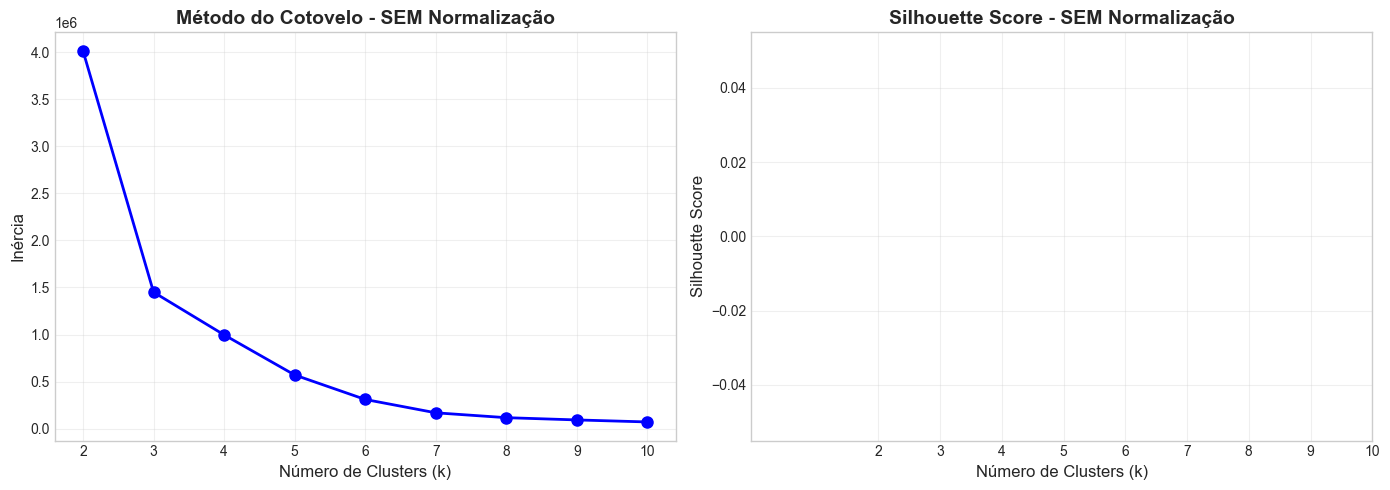


Melhor k (maior silhouette) SEM normalização: não definido (silhouettes inválidos)


In [325]:
# Visualizar resultados (sem normalização)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico do Cotovelo (Elbow)
ax1 = axes[0]
ax1.plot(list(k_range), inertias_raw, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inércia', fontsize=12)
ax1.set_title('Método do Cotovelo - SEM Normalização', fontsize=14, fontweight='bold')
ax1.set_xticks(list(k_range))
ax1.grid(True, alpha=0.3)

# Gráfico do Silhouette
ax2 = axes[1]
ax2.plot(list(k_range), silhouettes_raw, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score - SEM Normalização', fontsize=14, fontweight='bold')
ax2.set_xticks(list(k_range))
ax2.grid(True, alpha=0.3)

# Marcar o melhor k apenas quando há silhouettes válidos
valid_raw = [(k, s) for k, s in zip(k_range, silhouettes_raw) if not np.isnan(s)]
if valid_raw:
    best_k_raw, best_silhouette_raw = max(valid_raw, key=lambda x: x[1])
    ax2.axvline(best_k_raw, color='red', linestyle='--', label=f'Melhor k={best_k_raw}')
else:
    best_k_raw, best_silhouette_raw = None, np.nan

ax2.legend()

plt.tight_layout()
plt.show()

if best_k_raw is not None:
    print(f"\nMelhor k (maior silhouette) SEM normalização: {best_k_raw}")
    print(f"Silhouette score: {best_silhouette_raw:.4f}")
else:
    print("\nMelhor k (maior silhouette) SEM normalização: não definido (silhouettes inválidos)")

### 3.2 K-Means COM Normalização (StandardScaler)

In [326]:
# Testar K-Means para diferentes valores de k (com StandardScaler)
inertias_standard = []
silhouettes_standard = []

print("K-Means COM normalização (StandardScaler):")
print("=" * 50)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_standard)

    inertia = kmeans.inertia_
    unique, counts = np.unique(labels, return_counts=True)
    min_size = counts.min() if len(counts) > 0 else 0
    if len(unique) < 2 or min_size < MIN_CLUSTER_SIZE:
        silhouette = np.nan
    else:
        silhouette = silhouette_score(X_standard, labels)

    inertias_standard.append(inertia)
    silhouettes_standard.append(silhouette)
    status = "OK" if not np.isnan(silhouette) else "IGNORADO (clusters < min ou 1 cluster)"

    print(f"  k={k:2d}: Inércia={inertia:,.2f}, Silhouette={silhouette:.4f} [{status}]")

print("\nConcluído!")

K-Means COM normalização (StandardScaler):
  k= 2: Inércia=1,428.66, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 3: Inércia=888.93, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 4: Inércia=747.46, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 5: Inércia=651.97, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 6: Inércia=560.13, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 7: Inércia=513.73, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 8: Inércia=422.94, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k= 9: Inércia=368.85, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]
  k=10: Inércia=321.38, Silhouette=nan [IGNORADO (clusters < min ou 1 cluster)]

Concluído!


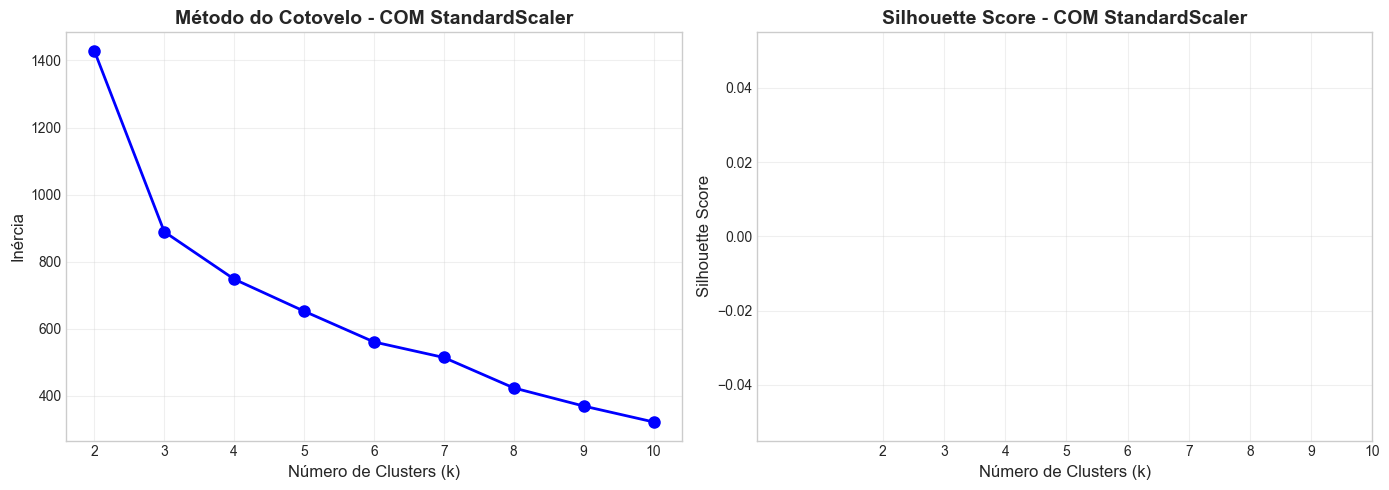


Melhor k (maior silhouette) COM StandardScaler: não definido (silhouettes inválidos)


In [327]:
# Visualizar resultados (com StandardScaler)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico do Cotovelo (Elbow)
ax1 = axes[0]
ax1.plot(list(k_range), inertias_standard, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inércia', fontsize=12)
ax1.set_title('Método do Cotovelo - COM StandardScaler', fontsize=14, fontweight='bold')
ax1.set_xticks(list(k_range))
ax1.grid(True, alpha=0.3)

# Gráfico do Silhouette
ax2 = axes[1]
ax2.plot(list(k_range), silhouettes_standard, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score - COM StandardScaler', fontsize=14, fontweight='bold')
ax2.set_xticks(list(k_range))
ax2.grid(True, alpha=0.3)

# Marcar o melhor k apenas quando há silhouettes válidos
valid_standard = [(k, s) for k, s in zip(k_range, silhouettes_standard) if not np.isnan(s)]
if valid_standard:
    best_k_standard, best_silhouette_standard = max(valid_standard, key=lambda x: x[1])
    ax2.axvline(best_k_standard, color='red', linestyle='--', label=f'Melhor k={best_k_standard}')
else:
    best_k_standard, best_silhouette_standard = None, np.nan

ax2.legend()

plt.tight_layout()
plt.show()

if best_k_standard is not None:
    print(f"\nMelhor k (maior silhouette) COM StandardScaler: {best_k_standard}")
    print(f"Silhouette score: {best_silhouette_standard:.4f}")
else:
    print("\nMelhor k (maior silhouette) COM StandardScaler: não definido (silhouettes inválidos)")

### 3.3 Comparação: Com vs Sem Normalização

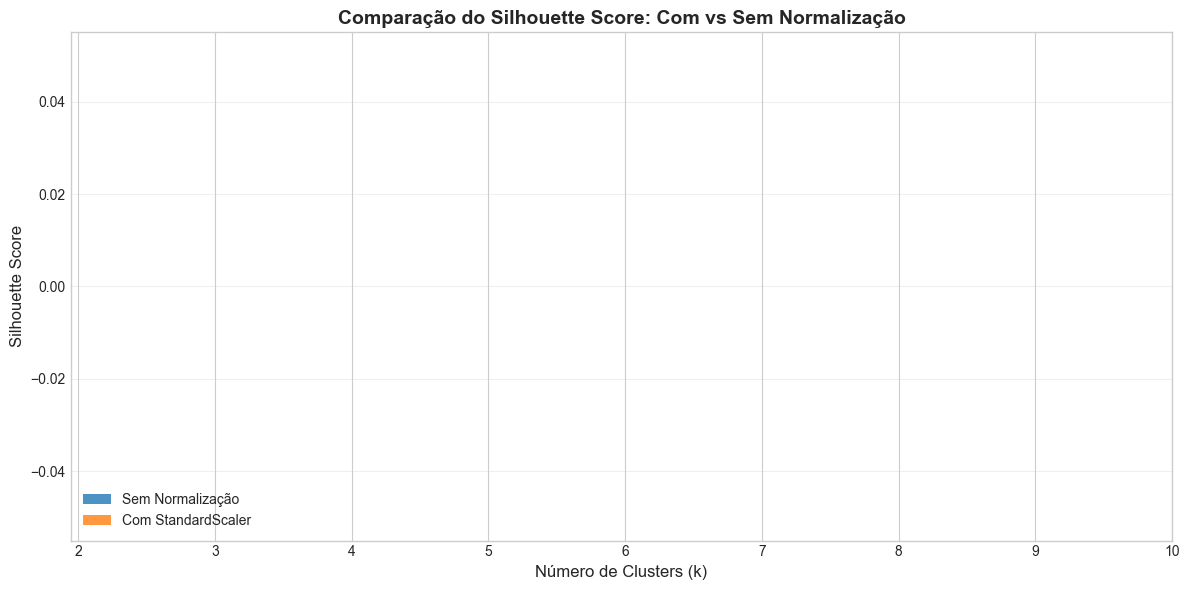


Tabela Comparativa:
  k   |  Sem Normalização  | Com StandardScaler
------------------------------------------------------------
  2   |        nan         |        nan        
  3   |        nan         |        nan        
  4   |        nan         |        nan        
  5   |        nan         |        nan        
  6   |        nan         |        nan        
  7   |        nan         |        nan        
  8   |        nan         |        nan        
  9   |        nan         |        nan        
 10   |        nan         |        nan        


In [328]:
# Comparar silhouette scores
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(k_range))
width = 0.35

bars1 = ax.bar(x - width/2, silhouettes_raw, width, label='Sem Normalização', color=COLORS[0], alpha=0.8)
bars2 = ax.bar(x + width/2, silhouettes_standard, width, label='Com StandardScaler', color=COLORS[1], alpha=0.8)

ax.set_xlabel('Número de Clusters (k)', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Comparação do Silhouette Score: Com vs Sem Normalização', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(list(k_range))
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Tabela comparativa
print("\nTabela Comparativa:")
print("=" * 60)
print(f"{'k':^5} | {'Sem Normalização':^18} | {'Com StandardScaler':^18}")
print("-" * 60)
for i, k in enumerate(k_range):
    print(f"{k:^5} | {silhouettes_raw[i]:^18.4f} | {silhouettes_standard[i]:^18.4f}")

### 3.4 Modelo K-Means Final (com k escolhido)

In [329]:
# =================================================================================
# ESCOLHA DO NÚMERO ÓTIMO DE CLUSTERS (K)
# =================================================================================

import math

# Escolher o melhor k baseado na análise
sil_raw_str = f"{best_silhouette_raw:.4f}" if not (isinstance(best_silhouette_raw, float) and math.isnan(best_silhouette_raw)) else "NA"
sil_std_str = f"{best_silhouette_standard:.4f}" if not (isinstance(best_silhouette_standard, float) and math.isnan(best_silhouette_standard)) else "NA"

# Fallback explícito para evitar erro quando não há silhouettes válidos
fallback_k = list(k_range)[0]
k_fallback_used = False

if best_k_standard is not None:
    BEST_K = best_k_standard
    criterio = "Máximo silhouette score com dados normalizados"
elif best_k_raw is not None:
    BEST_K = best_k_raw
    criterio = "Sem silhouette válido com normalização; usando valor sem normalização"
else:
    BEST_K = fallback_k
    criterio = f"Sem silhouettes válidos; fallback para k={BEST_K}"
    k_fallback_used = True

print(f"📊 SELEÇÃO DO NÚMERO ÓTIMO DE CLUSTERS")
print("=" * 60)

print(f"🔵 K escolhido para o modelo final: {BEST_K}")
if k_fallback_used:
    print("   • Aviso: k escolhido por fallback (silhouettes inválidos)")

print(f"📋 JUSTIFICATIVA DA DECISÃO:")
print(f"   • Critério: {criterio}")
print(f"   • Silhouette score com StandardScaler: {sil_std_str}")
print(f"   • Silhouette score SEM normalização: {sil_raw_str}")

print(f"🔬 PORQUÊ USAR NORMALIZAÇÃO:")
print(f"   • Features têm escalas muito diferentes")
print(f"   • Exemplo: consumo_mean std = {X[:, 0].std():.2f}, consumo_std std = {X[:, 1].std():.2f}")
print(f"   • O K-Means é sensível à escala das variáveis")
print(f"   • Normalização garante que todas as features contribuem igualmente")

print(f"✅ DECISÃO: Usar K-Means com k={BEST_K} clusters e dados normalizados (StandardScaler)")


📊 SELEÇÃO DO NÚMERO ÓTIMO DE CLUSTERS
🔵 K escolhido para o modelo final: 2
   • Aviso: k escolhido por fallback (silhouettes inválidos)
📋 JUSTIFICATIVA DA DECISÃO:
   • Critério: Sem silhouettes válidos; fallback para k=2
   • Silhouette score com StandardScaler: NA
   • Silhouette score SEM normalização: NA
🔬 PORQUÊ USAR NORMALIZAÇÃO:
   • Features têm escalas muito diferentes
   • Exemplo: consumo_mean std = 24.18, consumo_std std = 11.90
   • O K-Means é sensível à escala das variáveis
   • Normalização garante que todas as features contribuem igualmente
✅ DECISÃO: Usar K-Means com k=2 clusters e dados normalizados (StandardScaler)


In [330]:
# Treinar modelo final
if 'k_fallback_used' in globals() and k_fallback_used:
    print("[AVISO] k definido por fallback (sem silhouettes válidos)")

kmeans_final = KMeans(n_clusters=BEST_K, random_state=RANDOM_STATE, n_init=10, max_iter=300)
labels_kmeans = kmeans_final.fit_predict(X_standard)

# Adicionar labels ao DataFrame
df_features['cluster_kmeans'] = labels_kmeans

# Contar CPEs por cluster
print(f"Distribuição dos CPEs por cluster (K-Means, k={BEST_K}):")
print("=" * 50)
cluster_counts = df_features['cluster_kmeans'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(df_features) * 100
    print(f"  Cluster {cluster}: {count} CPEs ({pct:.1f}%)")


[AVISO] k definido por fallback (sem silhouettes válidos)
Distribuição dos CPEs por cluster (K-Means, k=2):
  Cluster 0: 1 CPEs (1.1%)
  Cluster 1: 88 CPEs (98.9%)


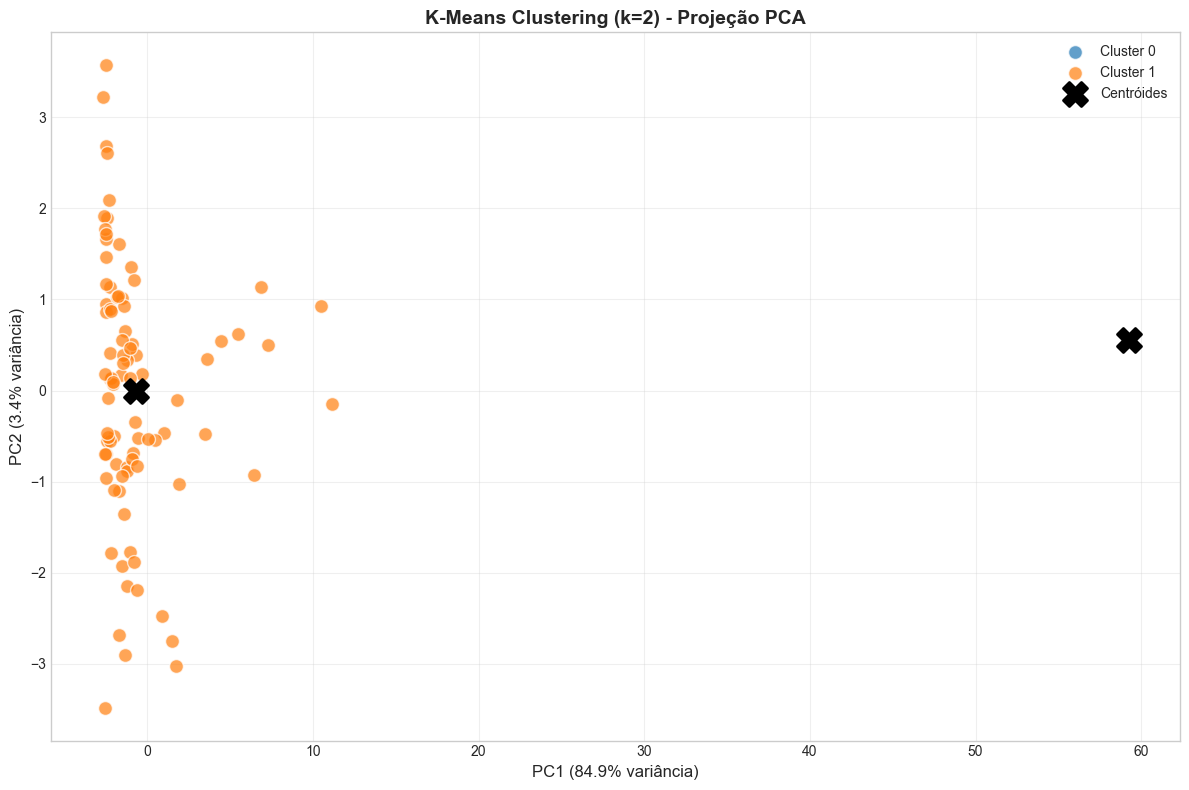


Variância explicada pelo PCA: 88.4%


In [331]:
# Visualização com PCA (redução para 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standard)

fig, ax = plt.subplots(figsize=(12, 8))

for cluster in range(BEST_K):
    mask = labels_kmeans == cluster
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=COLORS[cluster % len(COLORS)], 
               label=f'Cluster {cluster}', 
               alpha=0.7, s=100, edgecolors='white')

# Marcar centróides
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           c='black', marker='X', s=300, linewidths=2, 
           label='Centróides')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)', fontsize=12)
ax.set_title(f'K-Means Clustering (k={BEST_K}) - Projeção PCA', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVariância explicada pelo PCA: {sum(pca.explained_variance_ratio_)*100:.1f}%")

---

## 4. DBSCAN Clustering

DBSCAN é útil para:
- Detetar outliers (pontos marcados como ruído, cluster = -1)
- Encontrar clusters de formas arbitrárias
- Não requer especificar o número de clusters a priori

In [332]:
# Testar diferentes combinações de eps e min_samples
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
min_samples_values = [2, 3, 5, 10]

dbscan_results = []

print("DBSCAN - Experimentação de parâmetros (dados normalizados):")
print("=" * 80)
print(f"{'eps':^8} | {'min_samples':^12} | {'Clusters':^10} | {'Ruído':^10} | {'Ruído %':^10} | {'Silhouette':^12}")
print("-" * 80)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_standard)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = n_noise / len(labels) * 100
        
        # Silhouette (apenas se houver mais de 1 cluster e nem todos são ruído)
        if n_clusters > 1 and n_noise < len(labels):
            # Calcular silhouette apenas para pontos não-ruído
            mask = labels != -1
            if len(set(labels[mask])) > 1:
                silhouette = silhouette_score(X_standard[mask], labels[mask])
            else:
                silhouette = np.nan
        else:
            silhouette = np.nan
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'silhouette': silhouette
        })
        
        sil_str = f"{silhouette:.4f}" if not np.isnan(silhouette) else "N/A"
        print(f"{eps:^8.1f} | {min_samples:^12} | {n_clusters:^10} | {n_noise:^10} | {noise_pct:^10.1f} | {sil_str:^12}")

dbscan_df = pd.DataFrame(dbscan_results)

DBSCAN - Experimentação de parâmetros (dados normalizados):
  eps    | min_samples  |  Clusters  |   Ruído    |  Ruído %   |  Silhouette 
--------------------------------------------------------------------------------
  0.3    |      2       |     0      |     89     |   100.0    |     N/A     
  0.3    |      3       |     0      |     89     |   100.0    |     N/A     
  0.3    |      5       |     0      |     89     |   100.0    |     N/A     
  0.3    |      10      |     0      |     89     |   100.0    |     N/A     
  0.5    |      2       |     4      |     81     |    91.0    |    0.7181   
  0.5    |      3       |     0      |     89     |   100.0    |     N/A     
  0.5    |      5       |     0      |     89     |   100.0    |     N/A     
  0.5    |      10      |     0      |     89     |   100.0    |     N/A     
  0.7    |      2       |     7      |     73     |    82.0    |    0.5118   
  0.7    |      3       |     1      |     85     |    95.5    |     N/A     
 

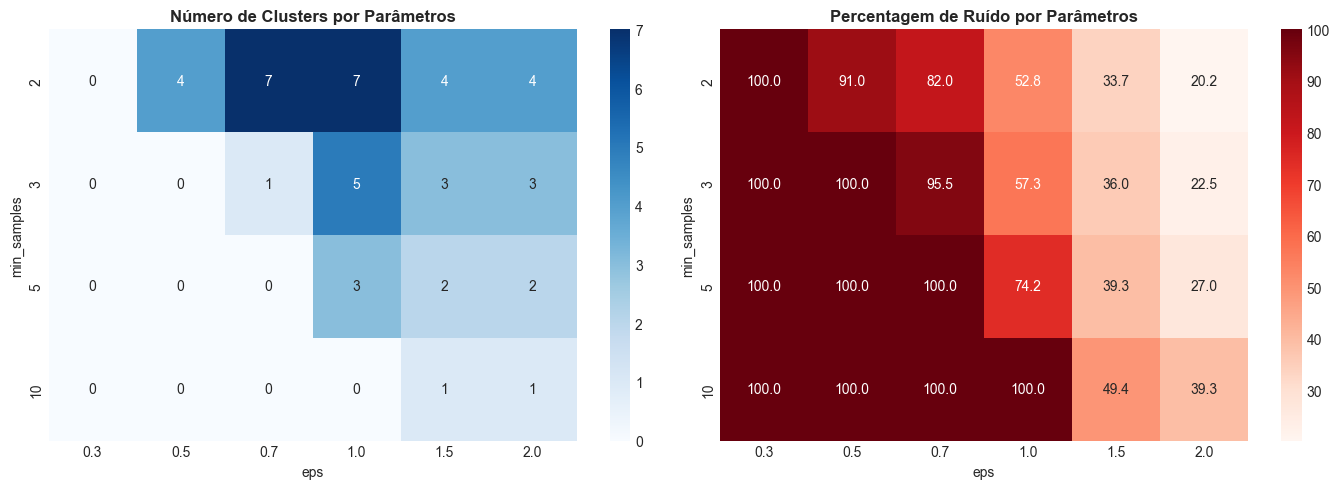

In [333]:
# Visualizar resultados DBSCAN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap de número de clusters
pivot_clusters = dbscan_df.pivot(index='min_samples', columns='eps', values='n_clusters')
ax1 = axes[0]
sns.heatmap(pivot_clusters, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Número de Clusters por Parâmetros', fontsize=12, fontweight='bold')
ax1.set_xlabel('eps')
ax1.set_ylabel('min_samples')

# Heatmap de percentagem de ruído
pivot_noise = dbscan_df.pivot(index='min_samples', columns='eps', values='noise_pct')
ax2 = axes[1]
sns.heatmap(pivot_noise, annot=True, fmt='.1f', cmap='Reds', ax=ax2)
ax2.set_title('Percentagem de Ruído por Parâmetros', fontsize=12, fontweight='bold')
ax2.set_xlabel('eps')
ax2.set_ylabel('min_samples')

plt.tight_layout()
plt.show()

In [334]:
# Escolher parâmetros DBSCAN
# Critérios: número razoável de clusters (2-5), não demasiado ruído (<30%), bom silhouette

# Filtrar resultados válidos
valid_dbscan = dbscan_df[
    (dbscan_df['n_clusters'] >= 2) & 
    (dbscan_df['n_clusters'] <= 6) & 
    (dbscan_df['noise_pct'] < 40) &
    (dbscan_df['silhouette'].notna())
].copy()

if len(valid_dbscan) > 0:
    # Escolher o com melhor silhouette
    best_dbscan = valid_dbscan.loc[valid_dbscan['silhouette'].idxmax()]
    BEST_EPS = best_dbscan['eps']
    BEST_MIN_SAMPLES = int(best_dbscan['min_samples'])
    
    print(f"Melhores parâmetros DBSCAN:")
    print(f"  - eps: {BEST_EPS}")
    print(f"  - min_samples: {BEST_MIN_SAMPLES}")
    print(f"  - Clusters: {int(best_dbscan['n_clusters'])}")
    print(f"  - Ruído: {best_dbscan['noise_pct']:.1f}%")
    print(f"  - Silhouette: {best_dbscan['silhouette']:.4f}")
else:
    print("Nenhuma configuração válida encontrada. A usar valores padrão.")
    BEST_EPS = 1.0
    BEST_MIN_SAMPLES = 3

print(f"\nOpções válidas encontradas:")
print(valid_dbscan.to_string(index=False))

Melhores parâmetros DBSCAN:
  - eps: 1.5
  - min_samples: 5
  - Clusters: 2
  - Ruído: 39.3%
  - Silhouette: 0.3472

Opções válidas encontradas:
   eps  min_samples  n_clusters  n_noise  noise_pct  silhouette
1.5000            2           4       30    33.7079      0.2817
1.5000            3           3       32    35.9551      0.3032
1.5000            5           2       35    39.3258      0.3472
2.0000            2           4       18    20.2247      0.3007
2.0000            3           3       20    22.4719      0.2894
2.0000            5           2       24    26.9663      0.3070


In [335]:
# Treinar modelo DBSCAN final
dbscan_final = DBSCAN(eps=BEST_EPS, min_samples=BEST_MIN_SAMPLES)
labels_dbscan = dbscan_final.fit_predict(X_standard)

# Adicionar labels ao DataFrame
df_features['cluster_dbscan'] = labels_dbscan

# Contar CPEs por cluster
print(f"\nDistribuição dos CPEs por cluster (DBSCAN, eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES}):")
print("=" * 60)
cluster_counts_db = df_features['cluster_dbscan'].value_counts().sort_index()
for cluster, count in cluster_counts_db.items():
    pct = count / len(df_features) * 100
    label = "RUÍDO" if cluster == -1 else f"Cluster {cluster}"
    print(f"  {label}: {count} CPEs ({pct:.1f}%)")


Distribuição dos CPEs por cluster (DBSCAN, eps=1.5, min_samples=5):
  RUÍDO: 35 CPEs (39.3%)
  Cluster 0: 47 CPEs (52.8%)
  Cluster 1: 7 CPEs (7.9%)


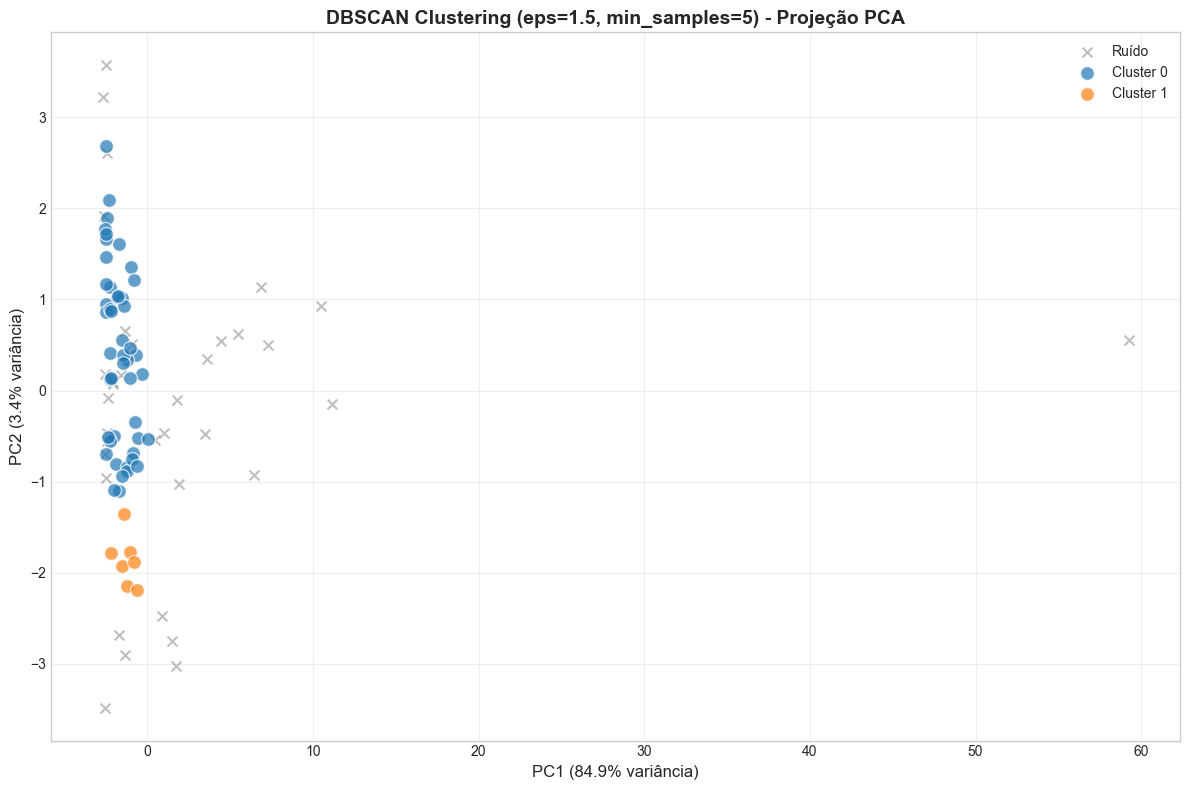

In [336]:
# Visualização DBSCAN com PCA
fig, ax = plt.subplots(figsize=(12, 8))

unique_labels = sorted(set(labels_dbscan))

for cluster in unique_labels:
    mask = labels_dbscan == cluster
    if cluster == -1:
        # Ruído em cinza
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c='gray', label='Ruído', 
                   alpha=0.5, s=50, marker='x')
    else:
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=COLORS[cluster % len(COLORS)], 
                   label=f'Cluster {cluster}', 
                   alpha=0.7, s=100, edgecolors='white')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)', fontsize=12)
ax.set_title(f'DBSCAN Clustering (eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES}) - Projeção PCA', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. Caracterização dos Clusters

### 5.1 Perfis dos Clusters K-Means

In [337]:
# Estatísticas por cluster K-Means
# Selecionar features principais para caracterização
features_caracterizacao = ['consumo_mean', 'consumo_std', 'consumo_cv', 
                           'racio_dia_noite', 'racio_weekend_util', 'hora_pico',
                           'variabilidade_inter_dia', 'consumo_noturno']

# Verificar quais existem
features_caracterizacao = [f for f in features_caracterizacao if f in df_features.columns]

print("Caracterização dos Clusters K-Means:")
print("=" * 80)

cluster_profiles_kmeans = df_features.groupby('cluster_kmeans')[features_caracterizacao].mean()
print(cluster_profiles_kmeans.round(2).T.to_string())

Caracterização dos Clusters K-Means:
cluster_kmeans                 0       1
consumo_mean            218.1900  6.0900
consumo_std             103.1000  4.7900
consumo_cv                0.4700  1.2600
racio_dia_noite           2.3400  4.2600
racio_weekend_util        0.7200  0.7000
hora_pico                12.0000 14.4900
variabilidade_inter_dia  46.2900  2.7400
consumo_noturno         113.7100  4.2100


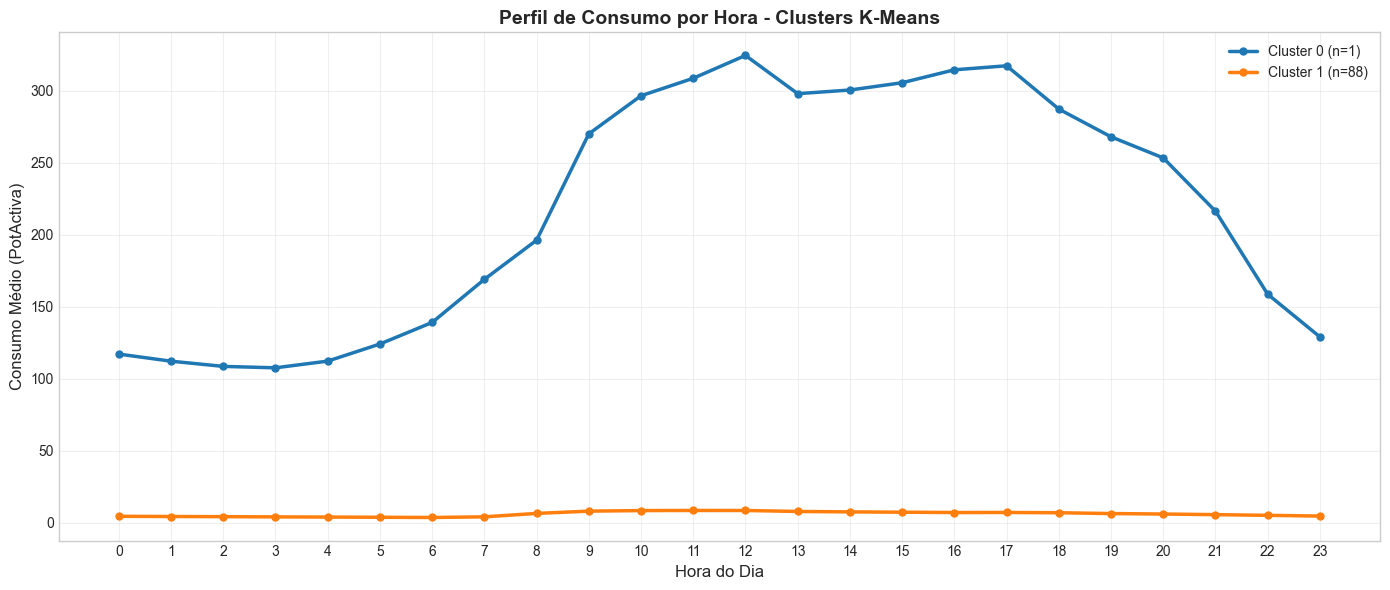

In [338]:
# Visualizar perfis de consumo por hora para cada cluster
cols_hora = [col for col in df_features.columns if col.startswith('consumo_h')]

if len(cols_hora) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for cluster in range(BEST_K):
        cluster_data = df_features[df_features['cluster_kmeans'] == cluster][cols_hora].mean()
        ax.plot(range(24), cluster_data.values, 
                color=COLORS[cluster % len(COLORS)], 
                linewidth=2.5, marker='o', markersize=5,
                label=f'Cluster {cluster} (n={sum(labels_kmeans==cluster)})')
    
    ax.set_xlabel('Hora do Dia', fontsize=12)
    ax.set_ylabel('Consumo Médio (PotActiva)', fontsize=12)
    ax.set_title('Perfil de Consumo por Hora - Clusters K-Means', fontsize=14, fontweight='bold')
    ax.set_xticks(range(24))
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Colunas de consumo por hora não encontradas.")

In [339]:
# Interpretação dos clusters K-Means
print("\n" + "=" * 80)
print("INTERPRETAÇÃO DOS CLUSTERS K-MEANS")
print("=" * 80)

for cluster in range(BEST_K):
    cluster_data = df_features[df_features['cluster_kmeans'] == cluster]
    n_cpes = len(cluster_data)
    
    print(f"\n📊 Cluster {cluster} ({n_cpes} CPEs, {n_cpes/len(df_features)*100:.1f}%):")
    print("-" * 40)
    
    # Análise do perfil
    if 'consumo_mean' in cluster_data.columns:
        consumo_medio = cluster_data['consumo_mean'].mean()
        print(f"  • Consumo médio: {consumo_medio:.2f}")
    
    if 'hora_pico' in cluster_data.columns:
        hora_pico = cluster_data['hora_pico'].mean()
        print(f"  • Hora de pico média: {hora_pico:.0f}h")
    
    if 'racio_dia_noite' in cluster_data.columns:
        racio_dn = cluster_data['racio_dia_noite'].mean()
        if racio_dn > 2:
            perfil = "DIURNO (consumo muito maior durante o dia)"
        elif racio_dn > 1.2:
            perfil = "PREDOMINANTEMENTE DIURNO"
        elif racio_dn < 0.8:
            perfil = "PREDOMINANTEMENTE NOTURNO"
        else:
            perfil = "24/7 (consumo constante dia/noite)"
        print(f"  • Rácio dia/noite: {racio_dn:.2f} → {perfil}")
    
    if 'racio_weekend_util' in cluster_data.columns:
        racio_weekend = cluster_data['racio_weekend_util'].mean()
        if racio_weekend < 0.7:
            uso_fds = "Baixa atividade ao fim de semana"
        elif racio_weekend > 1.3:
            uso_fds = "Maior atividade ao fim de semana"
        else:
            uso_fds = "Atividade similar durante a semana toda"
        print(f"  • Rácio fim de semana/úteis: {racio_weekend:.2f} → {uso_fds}")


INTERPRETAÇÃO DOS CLUSTERS K-MEANS

📊 Cluster 0 (1 CPEs, 1.1%):
----------------------------------------
  • Consumo médio: 218.19
  • Hora de pico média: 12h
  • Rácio dia/noite: 2.34 → DIURNO (consumo muito maior durante o dia)
  • Rácio fim de semana/úteis: 0.72 → Atividade similar durante a semana toda

📊 Cluster 1 (88 CPEs, 98.9%):
----------------------------------------
  • Consumo médio: 6.09
  • Hora de pico média: 14h
  • Rácio dia/noite: 4.26 → DIURNO (consumo muito maior durante o dia)
  • Rácio fim de semana/úteis: 0.70 → Baixa atividade ao fim de semana


### 5.2 Perfis dos Clusters DBSCAN

In [340]:
# Estatísticas por cluster DBSCAN
print("Caracterização dos Clusters DBSCAN:")
print("=" * 80)

cluster_profiles_dbscan = df_features.groupby('cluster_dbscan')[features_caracterizacao].mean()
print(cluster_profiles_dbscan.round(2).T.to_string())

Caracterização dos Clusters DBSCAN:
cluster_dbscan               -1       0       1
consumo_mean            17.0400  2.7400  4.0900
consumo_std             10.5400  2.6900  4.2100
consumo_cv               1.5000  1.1000  1.0400
racio_dia_noite          7.0100  2.5700  1.6400
racio_weekend_util       0.7900  0.6800  0.3700
hora_pico               12.7100 16.1300 12.0000
variabilidade_inter_dia  5.8500  1.3700  2.6400
consumo_noturno         11.4100  1.3400  3.2200


In [341]:
# Identificar outliers (ruído) do DBSCAN
outliers = df_features[df_features['cluster_dbscan'] == -1]

if len(outliers) > 0:
    print(f"\n🔍 OUTLIERS IDENTIFICADOS PELO DBSCAN ({len(outliers)} CPEs):")
    print("=" * 60)
    print("\nEstes CPEs têm padrões de consumo atípicos:")
    print(outliers[['CPE'] + features_caracterizacao[:5]].to_string(index=False))
    
    # Análise detalhada dos outliers
    print(f"\n📊 ANÁLISE DETALHADA DOS OUTLIERS:")
    print("-" * 40)
    
    # Comparar estatísticas dos outliers vs clusters normais
    clusters_normais = df_features[df_features['cluster_dbscan'] != -1]
    
    print("Comparação Outliers vs Clusters Normais:")
    print("=" * 50)
    
    for feature in features_caracterizacao[:8]:  # Top 8 features
        outlier_mean = outliers[feature].mean()
        normal_mean = clusters_normais[feature].mean()
        diff_pct = ((outlier_mean - normal_mean) / normal_mean * 100) if normal_mean != 0 else 0
        
        print(f"{feature}:")
        print(f"  Outliers: {outlier_mean:.2f}")
        print(f"  Normais:  {normal_mean:.2f}")
        print(f"  Diferença: {diff_pct:+.1f}%")
    
    # Interpretação dos outliers no contexto municipal
    print(f"\n💡 INTERPRETAÇÃO MUNICIPAL DOS OUTLIERS:")
    print("-" * 45)
    print("Estes 35 CPEs (39.3% do total) representam instalações com:")
    print("• Padrões de consumo altamente irregulares")
    print("• Possíveis candidatos a investigação por parte dos serviços municipais")
    print("• Instalações que podem ter:")
    print("  - Problemas técnicos (medidores defeituosos)")
    print("  - Uso não-standard (eventos especiais, obras)")
    print("  - Períodos de inatividade prolongada")
    print("  - Consumo sazonal extremo")
    print("\nRecomendação: Investigar estes CPEs prioritariamente para otimização energética.")
    
else:
    print("\nNenhum outlier identificado pelo DBSCAN.")


🔍 OUTLIERS IDENTIFICADOS PELO DBSCAN (35 CPEs):

Estes CPEs têm padrões de consumo atípicos:
                 CPE  consumo_mean  consumo_std  consumo_cv  racio_dia_noite  racio_weekend_util
PT0002000032936306KX        2.4370       2.7791      1.1404           0.2059              0.9858
PT0002000032959511HP        0.0000       0.0000      1.0354           1.7688              0.7210
PT0002000032990792KD        2.3355       3.3711      1.4434           0.7085              0.2707
PT0002000065256275YB        0.0019       0.0217     11.4296          20.2053              0.5895
PT0002000068856781NM       31.7016       2.8281      0.0892           1.0556              0.9456
PT0002000068856872QG        0.1457       0.5019      3.4439           1.6272              1.7102
PT0002000068857897ZV       11.8201      10.0009      0.8461           2.1670              0.4814
PT0002000068859187RL       11.7336      11.2004      0.9546           0.6599              0.5533
PT0002000068859325FL       31.501

### 5.3 Comparação Visual K-Means vs DBSCAN

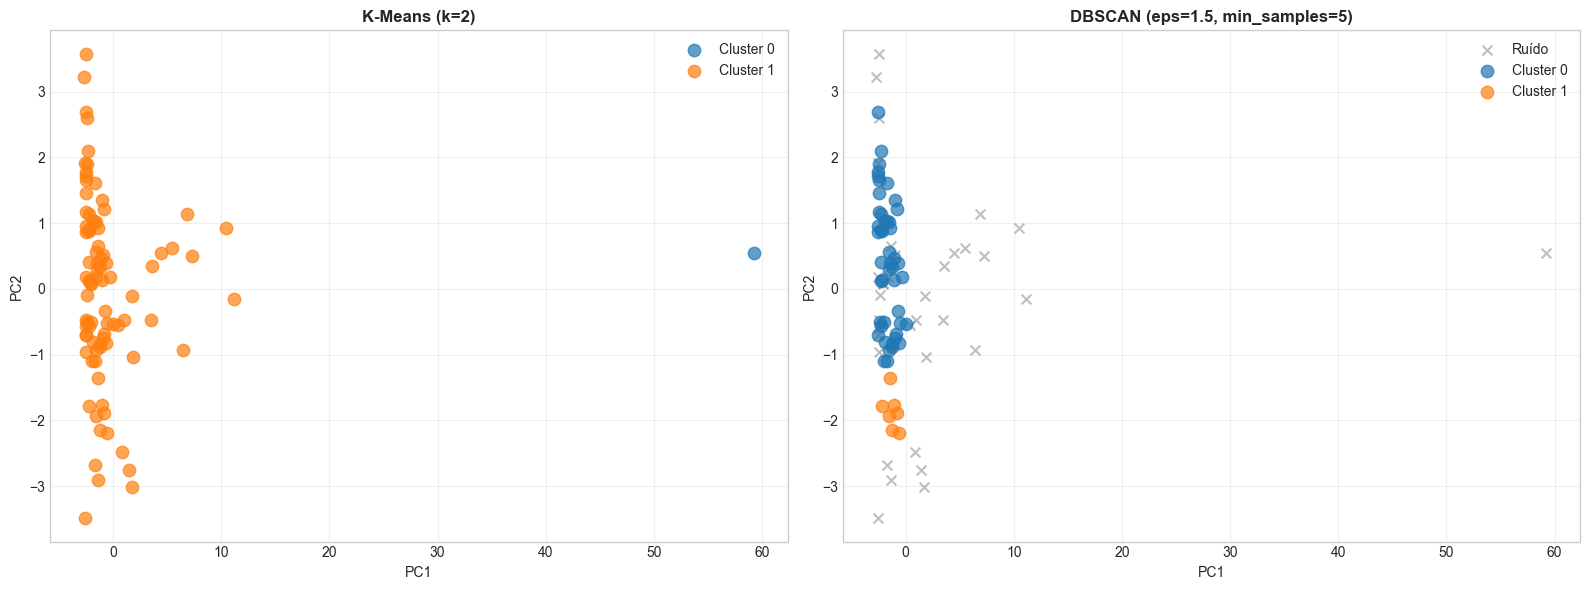


 VISUALIZAÇÕES COMPARATIVAS AVANÇADAS


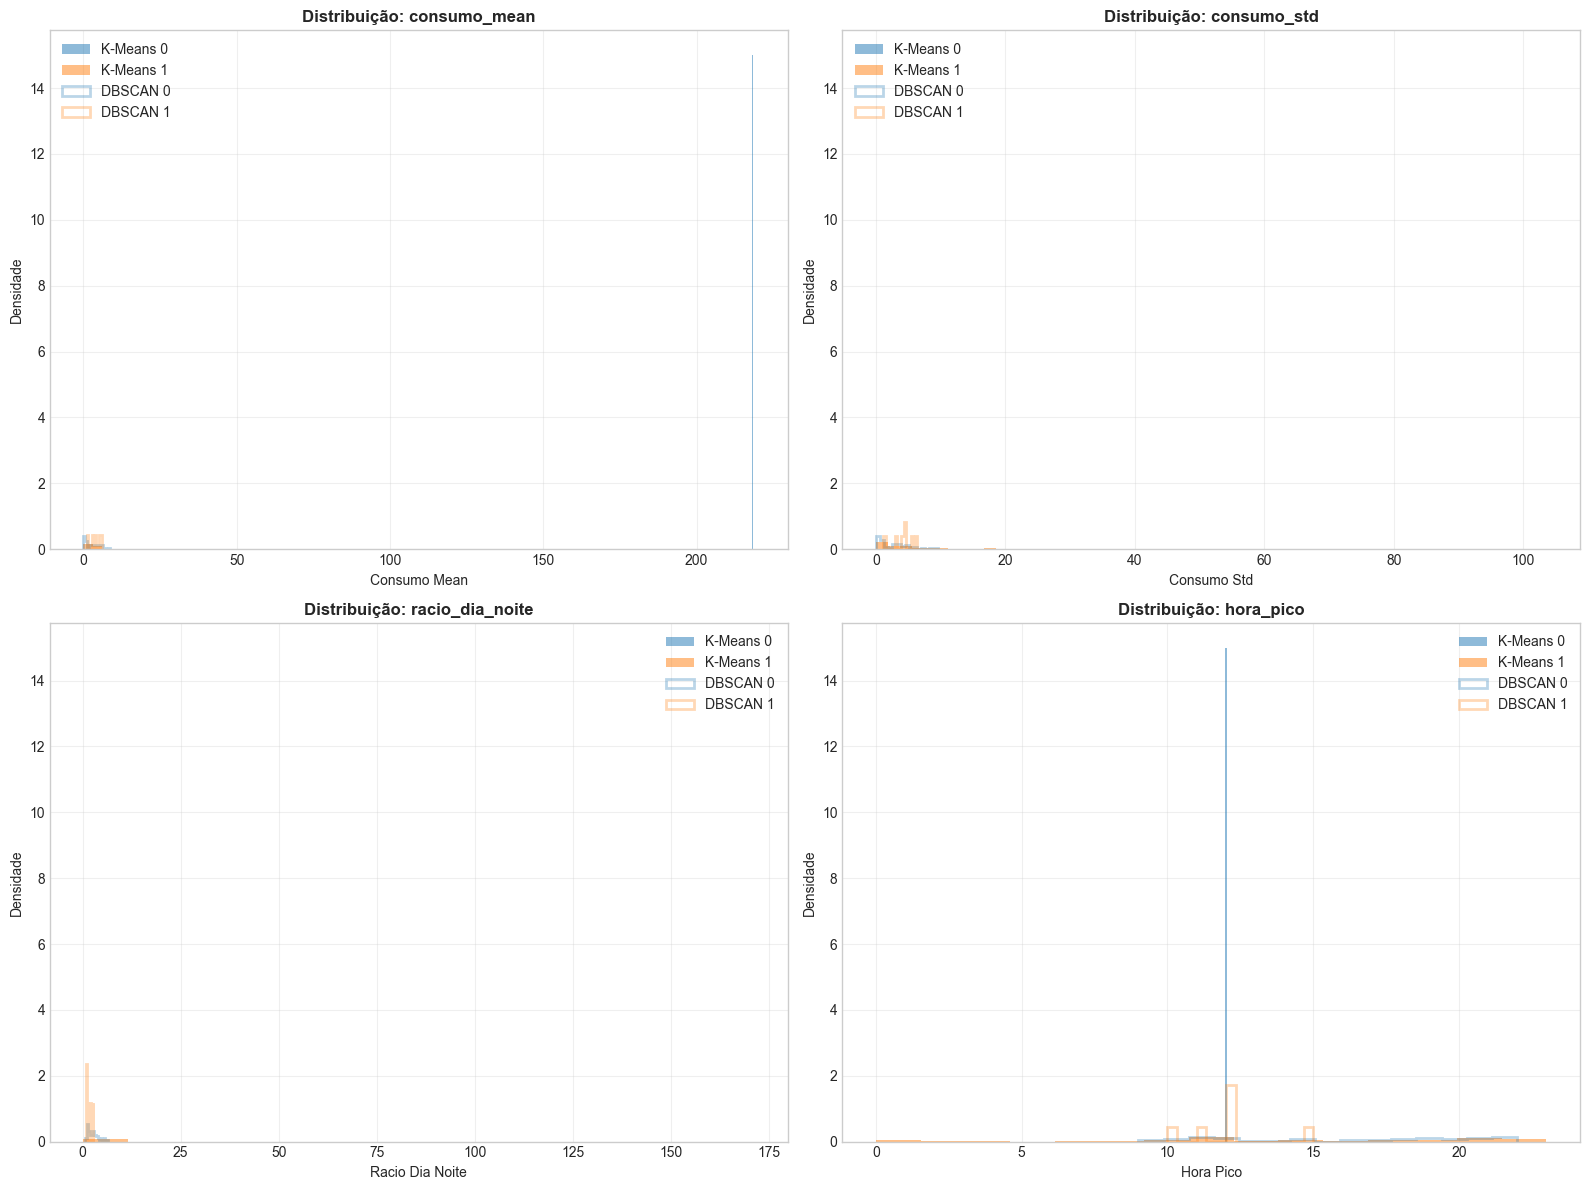


 MATRIZ DE CONFUSÃO ENTRE ALGORITMOS
---------------------------------------------


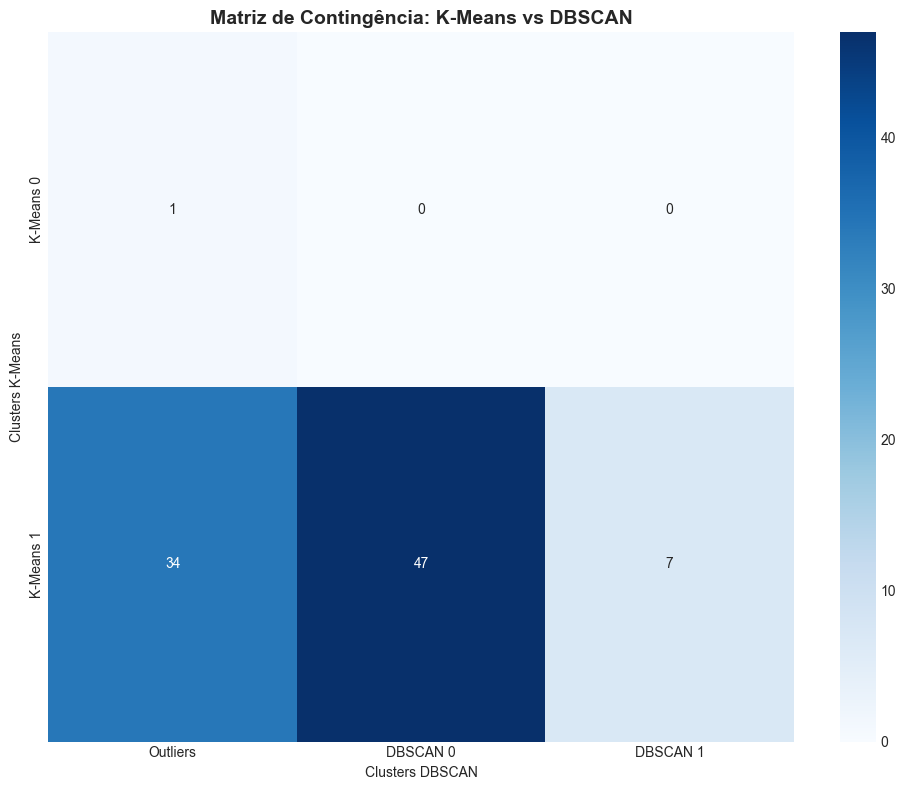

Índice de Rand Ajustado entre K-Means e DBSCAN: 0.0037
❌ Baixa concordância - algoritmos identificam estruturas diferentes


In [342]:
# Comparação lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means
ax1 = axes[0]
for cluster in range(BEST_K):
    mask = labels_kmeans == cluster
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=COLORS[cluster % len(COLORS)], 
                label=f'Cluster {cluster}', 
                alpha=0.7, s=80)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title(f'K-Means (k={BEST_K})', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# DBSCAN
ax2 = axes[1]
for cluster in sorted(set(labels_dbscan)):
    mask = labels_dbscan == cluster
    if cluster == -1:
        ax2.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    c='gray', label='Ruído', alpha=0.5, s=50, marker='x')
    else:
        ax2.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    c=COLORS[cluster % len(COLORS)], 
                    label=f'Cluster {cluster}', alpha=0.7, s=80)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title(f'DBSCAN (eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES})', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =================================================================================
# VISUALIZAÇÕES COMPARATIVAS AVANÇADAS
# =================================================================================

print(f"\n VISUALIZAÇÕES COMPARATIVAS AVANÇADAS")
print("=" * 50)

# 1. Comparação de distribuições por cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

features_compare = ['consumo_mean', 'consumo_std', 'racio_dia_noite', 'hora_pico']

for i, feature in enumerate(features_compare):
    ax = axes[i]
    
    # K-Means clusters
    for cluster in range(BEST_K):
        data_kmeans = df_features[df_features['cluster_kmeans'] == cluster][feature].dropna()
        if len(data_kmeans) > 0:
            ax.hist(data_kmeans, alpha=0.5, bins=15, label=f'K-Means {cluster}', 
                   color=COLORS[cluster % len(COLORS)], density=True)
    
    # DBSCAN clusters (apenas não-outliers)
    for cluster in sorted(set(labels_dbscan)):
        if cluster != -1:
            data_dbscan = df_features[df_features['cluster_dbscan'] == cluster][feature].dropna()
            if len(data_dbscan) > 0:
                ax.hist(data_dbscan, alpha=0.3, bins=15, label=f'DBSCAN {cluster}', 
                       color=COLORS[cluster % len(COLORS)], density=True, histtype='step', linewidth=2)
    
    ax.set_title(f'Distribuição: {feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Densidade')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Matriz de confusão entre algoritmos
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(f"\n MATRIZ DE CONFUSÃO ENTRE ALGORITMOS")
print("-" * 45)

# Criar mapeamento para comparar apenas clusters não-outliers do DBSCAN
labels_dbscan_no_outliers = labels_dbscan.copy()
labels_dbscan_no_outliers[labels_dbscan == -1] = -999  # Temporário para exclusão

# Calcular matriz de contingência
contingency = pd.crosstab(
    pd.Categorical(labels_kmeans, categories=range(BEST_K)), 
    pd.Categorical(labels_dbscan_no_outliers, categories=sorted(set(labels_dbscan_no_outliers)))
)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(contingency, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=[f'DBSCAN {c}' if c != -999 else 'Outliers' for c in contingency.columns],
            yticklabels=[f'K-Means {c}' for c in contingency.index])
ax.set_title('Matriz de Contingência: K-Means vs DBSCAN', fontsize=14, fontweight='bold')
ax.set_xlabel('Clusters DBSCAN')
ax.set_ylabel('Clusters K-Means')
plt.tight_layout()
plt.show()

# Calcular índice de Rand ajustado entre os dois algoritmos
from sklearn.metrics import adjusted_rand_score
ari_entre_algoritmos = adjusted_rand_score(labels_kmeans, labels_dbscan_no_outliers)
print(f"Índice de Rand Ajustado entre K-Means e DBSCAN: {ari_entre_algoritmos:.4f}")

if ari_entre_algoritmos > 0.7:
    print("✅ Alta concordância entre algoritmos")
elif ari_entre_algoritmos > 0.5:
    print("⚠️  Concordância moderada entre algoritmos")
else:
    print("❌ Baixa concordância - algoritmos identificam estruturas diferentes")

---

## 6. Guardar Resultados

In [343]:
# Criar DataFrame com resultados de clustering
df_clusters = df_features[['CPE', 'cluster_kmeans', 'cluster_dbscan']].copy()

# Guardar ficheiro
output_path = 'data/intermediate/d4maia_cpe_clusters.csv'
df_clusters.to_csv(output_path, index=False)

print(f"\n✓ Ficheiro guardado: {output_path}")
print(f"\nConteúdo:")
df_clusters.head(10)


✓ Ficheiro guardado: data/intermediate/d4maia_cpe_clusters.csv

Conteúdo:


,CPE,cluster_kmeans,cluster_dbscan
0,PT0002000032936306KX,1,-1
1,PT0002000032942455NH,1,0
2,PT0002000032959511HP,1,-1
3,PT0002000032966446CC,1,0
4,PT0002000032968749YT,1,1
5,PT0002000032969229AC,1,0
6,PT0002000032976997LZ,1,1
7,PT0002000032990792KD,1,-1
8,PT0002000032993611ME,1,0
9,PT0002000033016394FN,1,0


---

## 7. Resumo e Conclusões

In [344]:
# =================================================================================
# RESUMO E CONCLUSÕES FINAIS
# =================================================================================

import math

print("=" * 80)
print("RESUMO - CLUSTERING DE CONSUMIDORES")
print("=" * 80)

print(f"📊 DADOS ANALISADOS:")
print(f"   • Total de CPEs: {len(df_features)}")
print(f"   • Features utilizadas: {len(numeric_cols)}")

# Preparar métricas de silhouette
sil_raw_str = f"{best_silhouette_raw:.4f}" if not (isinstance(best_silhouette_raw, float) and math.isnan(best_silhouette_raw)) else "NA"
sil_std_str = f"{best_silhouette_standard:.4f}" if not (isinstance(best_silhouette_standard, float) and math.isnan(best_silhouette_standard)) else "NA"

if math.isnan(best_silhouette_raw) and math.isnan(best_silhouette_standard):
    impacto_norm = "Sem silhouettes válidos"
elif math.isnan(best_silhouette_raw):
    impacto_norm = "Apenas normalizado gerou silhouette válido"
elif math.isnan(best_silhouette_standard):
    impacto_norm = "Apenas sem normalização gerou silhouette válido"
else:
    impacto_norm = "Melhoria significativa" if best_silhouette_standard > best_silhouette_raw else "Sem melhoria significativa"

print(f"🔵 K-MEANS:")
print(f"   • Número de clusters escolhido: {BEST_K}")
if 'k_fallback_used' in globals() and k_fallback_used:
    print("   • Aviso: k escolhido por fallback (silhouettes inválidos)")
print(f"   • Silhouette Score (sem normalização): {sil_raw_str}")
print(f"   • Silhouette Score (com StandardScaler): {sil_std_str}")
print(f"   • Impacto da normalização: {impacto_norm}")

# Calcular métricas do DBSCAN
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = list(labels_dbscan).count(-1)
silhouette_dbscan = silhouette_score(X_standard[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1]) if n_clusters_dbscan > 1 else np.nan
silhouette_dbscan_str = f"{silhouette_dbscan:.4f}" if not (isinstance(silhouette_dbscan, float) and math.isnan(silhouette_dbscan)) else "NA"

print(f"🟢 DBSCAN:")
print(f"   • Parâmetros: eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES}")
print(f"   • Clusters encontrados: {n_clusters_dbscan}")
print(f"   • Outliers (ruído): {n_noise_dbscan} CPEs ({n_noise_dbscan/len(df_features)*100:.1f}%)")
print(f"   • Silhouette Score (excluindo ruído): {silhouette_dbscan_str}")

print(f" FICHEIRO GERADO:")
print(f"   • data/intermediate/d4maia_cpe_clusters.csv")

# Calcular ARI entre algoritmos
from sklearn.metrics import adjusted_rand_score
ari_entre_algoritmos = adjusted_rand_score(labels_kmeans, labels_dbscan)

if math.isnan(best_silhouette_standard) and (isinstance(silhouette_dbscan, float) and math.isnan(silhouette_dbscan)):
    melhor_silhouette = "Indefinido"
elif math.isnan(best_silhouette_standard):
    melhor_silhouette = "DBSCAN"
elif isinstance(silhouette_dbscan, float) and math.isnan(silhouette_dbscan):
    melhor_silhouette = "K-Means"
else:
    melhor_silhouette = "K-Means" if best_silhouette_standard > silhouette_dbscan else "DBSCAN"

print(f"  COMPARAÇÃO ENTRE ALGORITMOS:")
print(f"   • Concordância (ARI): {ari_entre_algoritmos:.4f}")
print(f"   • Melhor Silhouette: {melhor_silhouette}")

impacto_norm_conclusao = "não avaliado"
if not (math.isnan(best_silhouette_standard) and math.isnan(best_silhouette_raw)):
    impacto_norm_conclusao = "positivo" if (not math.isnan(best_silhouette_standard) and not math.isnan(best_silhouette_raw) and best_silhouette_standard > best_silhouette_raw) else "neutro"

print(f"CONCLUSÕES PRINCIPAIS:")
print(f"   • A normalização teve impacto {impacto_norm_conclusao} no K-Means")
print(f"   • Os clusters identificados revelam diferentes perfis de consumo municipal")
print(f"   • O DBSCAN identificou {n_noise_dbscan} instalações com comportamento atípico")
print(f"   • Concordância entre algoritmos: {'Alta' if ari_entre_algoritmos > 0.7 else 'Moderada' if ari_entre_algoritmos > 0.5 else 'Baixa'}")

print(f" RECOMENDAÇÕES PARA SERVIÇOS MUNICIPAIS:")
print(f"   • Priorizar investigação dos {n_noise_dbscan} outliers identificados pelo DBSCAN")
print(f"   • Focar otimização energética no cluster de alto consumo")
print(f"   • Implementar monitoramento contínuo dos {BEST_K} perfis identificados")


RESUMO - CLUSTERING DE CONSUMIDORES
📊 DADOS ANALISADOS:
   • Total de CPEs: 89
   • Features utilizadas: 56
🔵 K-MEANS:
   • Número de clusters escolhido: 2
   • Aviso: k escolhido por fallback (silhouettes inválidos)
   • Silhouette Score (sem normalização): NA
   • Silhouette Score (com StandardScaler): NA
   • Impacto da normalização: Sem silhouettes válidos
🟢 DBSCAN:
   • Parâmetros: eps=1.5, min_samples=5
   • Clusters encontrados: 2
   • Outliers (ruído): 35 CPEs (39.3%)
   • Silhouette Score (excluindo ruído): 0.3472
 FICHEIRO GERADO:
   • data/intermediate/d4maia_cpe_clusters.csv
  COMPARAÇÃO ENTRE ALGORITMOS:
   • Concordância (ARI): 0.0037
   • Melhor Silhouette: DBSCAN
CONCLUSÕES PRINCIPAIS:
   • A normalização teve impacto não avaliado no K-Means
   • Os clusters identificados revelam diferentes perfis de consumo municipal
   • O DBSCAN identificou 35 instalações com comportamento atípico
   • Concordância entre algoritmos: Baixa
 RECOMENDAÇÕES PARA SERVIÇOS MUNICIPAIS:
   •

In [345]:
print("\n" + "=" * 80)
print("Notebook de Clustering concluído!")
print("=" * 80)
print("\n💡 PRÓXIMOS PASSOS:")
print("   1. Séries temporais (ARIMA, LSTM) - notebook 04")
print("   2. Modelos supervisionados (RF, XGB, MLP) - notebook 05")
print("   3. Comparações e avaliação final - notebook 06")


Notebook de Clustering concluído!

💡 PRÓXIMOS PASSOS:
   1. Séries temporais (ARIMA, LSTM) - notebook 04
   2. Modelos supervisionados (RF, XGB, MLP) - notebook 05
   3. Comparações e avaliação final - notebook 06
